In [4]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [ ]:
## Activate if necessary to install following packages

# !pip install svgutils
# !pip install ipywidgets

############################################################
# IMPORT FROM LIB, DECLARE FUNC, ETC.
############################################################
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout import via_stack, via_array

############################################################
# DEFINITION OF NMOS/PMOS
############################################################
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}
pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

# DISTANCE FOR SHIFTING (FREELY)
x_distance = 5 #jarak horizontal antar komponen
y_distance = 5 #jarak vertikal antar komponen

#########################################################
# - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
########################################################
pmos_input_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (6,6), # width of the input fet and feedback fet respectively.
        "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_input_config["pdk"]
pdk.activate()
width=pmos_input_config["width"]
length=pmos_input_config["length"]
fingers=pmos_input_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_input_config["dummy_1"]
dummy_2=pmos_input_config["dummy_2"]
tie_layers1=pmos_input_config["tie_layers1"]
tie_layers2=pmos_input_config["tie_layers2"]
sd_rmult=pmos_input_config["sd_rmult"]

pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )

top_level = Component("PMOS_PAIR_BIAS")
pfet1_ref = top_level << pfet1
pfet2_ref = top_level << pfet2

pfet1_ref.name = "PFET1"
pfet2_ref.name = "PFET2"

placement = pmos_input_config["placement"]

#Global Variable
compSep = gf180.util_max_metal_seperation() #rule dari gf180
padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180

if placement == "horizontal":
    pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")  

# For TAP RING for PMOS PAIR only
flattened_top = top_level.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

#########################################################
# - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
########################################################
pmos_bias_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_bias_config["pdk"]
width=pmos_bias_config["width"]
length=pmos_bias_config["length"]
fingers=pmos_bias_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_bias_config["dummy_1"]
dummy_2=pmos_bias_config["dummy_2"]
tie_layers1=pmos_bias_config["tie_layers1"]
tie_layers2=pmos_bias_config["tie_layers2"]
sd_rmult=pmos_bias_config["sd_rmult"]

bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
bias_ref = top_level << bias_pmos
bias_ref.name = "PFET_Bias"
bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)

#########################################################
# - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
########################################################
nmos_input_config = {
        "pdk1": gf180,  # PDK to use
        "placement1": "horizontal",  # can be "horizontal" or "vertical"
        "width1": (3, 3),  # width of the input fet and feedback fet respectively
        "length1": (3, 3),  # length of the input fet and feedback fet respectively
        "fingers1": (1, 1),  # number of fingers for each device
        "multipliers1": (1, 1),  # multipliers for each device
        "dummy_11": (True, True),  # dummies for input fet (left, right)
        "dummy_21": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult1": 1,  # thickness of the sd metal layer
}

# Activate PDK for NMOS input stage
pdk = nmos_input_config["pdk1"]
#pdk.activate()

# Extract parameters from PMOS input config
width       = nmos_input_config["width1"]
length      = nmos_input_config["length1"]
fingers     = nmos_input_config["fingers1"]
multipliers = nmos_input_config["multipliers1"]

dummy_1     = nmos_input_config["dummy_11"]
dummy_2     = nmos_input_config["dummy_21"]
tie_layers1 = nmos_input_config["tie_layers11"]
tie_layers2 = nmos_input_config["tie_layers21"]
sd_rmult    = nmos_input_config["sd_rmult1"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
# Buat pasangan NMOS
nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level1 = Component("NMOS_INPUT_PAIR")
nfet1_ref = top_level1 << nfet1
nfet2_ref = top_level1 << nfet2
nfet1_ref.name = "NFET1"
nfet2_ref.name = "NFET2"
nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.3)
nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.5)
# Additional Tap Ring for Deep N-Well
# Additional Guard Ring for Deep N-Well (PCOMP required by DN.3)
pcomp_tapring_nfet1 = tapring(
    pdk,
    enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2),
    sdlayer="n+s/d"   # ganti dari n+ ke p+ (PCOMP guard ring)
)
pcomp_tapring_nfet2 = tapring(
    pdk,
    enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2),
    sdlayer="n+s/d"
)
tring_ref1 = top_level1 << pcomp_tapring_nfet1
tring_ref2 = top_level1 << pcomp_tapring_nfet2
tring_ref1.name = "tring_ref1_nmos"
tring_ref2.name = "tring_ref2_nmos"
tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Placement
placement = nmos_input_config["placement1"]
shift_amount =  -prec_center(nfet1_ref)[0]
if placement == "horizontal":
    nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
    tring_ref1.movex(destination=shift_amount)
    tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
###############################################################
# - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
###############################################################
nmos_current_mirror_config = {
        "pdk2": gf180,  # PDK to use
        "placement2": "horizontal",  # can be "horizontal" or "vertical"
        "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
        "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
        "fingers2": (1, 1),  # number of fingers for each device
        "multipliers2": (1, 1),  # multipliers for each device
        "dummy_12": (True, True),  # dummies for input fet (left, right)
        "dummy_22": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult2": 1,  # thickness of the sd metal layer
}
# Activate PDK for NMOS Mirror Pair
pdk = nmos_current_mirror_config["pdk2"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = nmos_current_mirror_config["width2"]
length      = nmos_current_mirror_config["length2"]
fingers     = nmos_current_mirror_config["fingers2"]
multipliers = nmos_current_mirror_config["multipliers2"]
dummy_1     = nmos_current_mirror_config["dummy_12"]
dummy_2     = nmos_current_mirror_config["dummy_22"]
tie_layers1 = nmos_current_mirror_config["tie_layers12"]
tie_layers2 = nmos_current_mirror_config["tie_layers22"]
sd_rmult    = nmos_current_mirror_config["sd_rmult2"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
# Buat pasangan NMOS
nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level2 = Component("NMOS_MIRROR")
#top_level2 = Component(name="NMOS_Mirror_Pair")
nfet3_ref = top_level2 << nfet3
nfet4_ref = top_level2 << nfet4
nfet3_ref.name = "NFET3"
nfet4_ref.name = "NFET4"
nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement
placement = nmos_current_mirror_config["placement2"]
if placement == "horizontal":
    nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
#########################################################
# - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
#########################################################
pmos_diodes_connected_config={
        "pdk3": gf180, # pdk to use
        "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_13": (True,True), # dummy pattern for input fet (left,right)
        "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult3":1, # thickness of the sd metal layer.
}
# Activate PDK for PMOS input stage
pdk = pmos_diodes_connected_config["pdk3"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = pmos_diodes_connected_config["width3"]
length      = pmos_diodes_connected_config["length3"]
fingers     = pmos_diodes_connected_config["fingers3"]
multipliers = pmos_diodes_connected_config["multipliers3"]
dummy_1     = pmos_diodes_connected_config["dummy_13"]
dummy_2     = pmos_diodes_connected_config["dummy_23"]
tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
# PMOS-DIODE Pair
pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)

# Top level component
top_level3 = Component("PMOS_DIODE_PAIR")
pfet3_ref = top_level3 << pfet3
pfet4_ref = top_level3 << pfet4
pfet3_ref.name = "PFET3"
pfet4_ref.name = "PFET4"
pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement (horizontal)
placement = pmos_diodes_connected_config["placement3"]
if placement == "horizontal":
    pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")

############################################################################################
# TOP LEVEL DECLARATION IN 1 DISPLAY
###########################################################################################
ALL_TOP = Component("ALL_TOP")

# PMOS BIAS + PMOS PAIR 
pmos_ref = ALL_TOP << top_level
pmos_ref.name = "PMOS_BIAS"
pmos_ref.movex(0)   
pmos_ref.movey(0)

# NMOS PAIR
nmos_ref = ALL_TOP << top_level1
nmos_ref.name = "NMOS_Inp_Pair"
flattened_top = top_level1.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=2.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level1 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)

# NMOS CURRENT MIRROR
cm_ref = ALL_TOP << top_level2
cm_ref.name = "NMOS_Mirror_Pair"
flattened_top = top_level2.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.12))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level2 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)

# FOR PMOS DIODE CONNECTED
pmos_diode_ref = ALL_TOP << top_level3
pmos_diode_ref.name = "PMOS_Diode_Pair"
flattened_top = top_level3.flatten()

tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level3 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

###########################################################################################################
# FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
###########################################################################################################
flattened_top = ALL_TOP.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = ALL_TOP << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

##########################################################################################################
# VIA AND ROUTING INA
##########################################################################################################
# --- VIA DEF ---
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3

# --- VIA INPUT ---
# -- IN +
via_input_P = ALL_TOP << viam2m3
via_input_P.movex(-16).movey(-27.8)
via_to_input_P = ALL_TOP << viam2m3
via_to_input_P.movex(18.4).movey(-27.8)
# -- IN - 
via_input_N = ALL_TOP << viam2m3
via_input_N.movex(-16).movey(-28.8)
via_to_input_N = ALL_TOP << viam2m3
via_to_input_N.movex(21.8).movey(-28.8)

# --- VIA OUTPUT ---
# --- OUTPUT P
via_to_output_P = ALL_TOP << viam2m3
via_output_P = ALL_TOP << viam2m3
via_to_output_P.movex(19.6).movey(-7.3)
via_output_P.movex(55).movey(-7.3)
via_to_output_P_center = via_to_output_P.center

# --- OUTPUT N
via_output_N = ALL_TOP << viam2m3
via_output_N.movex(55).movey(-7.9)
via_to_output_N = ALL_TOP << viam2m3
via_to_output_N.movex(20.6).movey(-7.9)

# --- ROUTING (Vertical on M3) ---
# SYNTAX FULL EXAMPLE (use if needed only :))
#route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
#route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
ALL_TOP << route_hori_out_P
ALL_TOP << route_hori_out_N
route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
ALL_TOP << route_hori_in_P
ALL_TOP << route_hori_in_N

# --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])

pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center
via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])

pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center
via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_L --- LEFT SIDE
nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])

nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])

nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_L --- LEFT SIDE
nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_R --- RIGHT SIDE
nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])

# ROUTE FOR OUTPUT
route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
ALL_TOP << route_vertical_out_P
route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
ALL_TOP << route_vertical_out_N

# ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
# LEFT
pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
# RIGHT
pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])

# ROUTE FOR INPUT
route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
ALL_TOP << route_vertical_in_P
route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
ALL_TOP << route_vertical_in_N

# ROUTING C ROUTE
#ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
#ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
# top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
# CROUTE WITH EXTENSION FOOT
ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))

# VIA FOR VCM WAY
viaarray = via_array(pdk, "met2", "met3", (2,1))
VCM_via = ALL_TOP << viaarray
VCM_via.movex(-14).movey(-39.5)
via_to_vcm = ALL_TOP << viam2m3
via_to_vcm.movex(20.15).movey(-39.5)
#print(VCM_via.ports.keys())

# CENTER FOR Via to VCM
pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])

pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])

# ROUTE VERTICAL VCM
route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
ALL_TOP << route_vertical_VCM
# ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
ALL_TOP << route_hori_VCM

# TIE PAIR
# -- NMOS
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
# SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
via_source_pmos_bias = ALL_TOP << viam2m3
via_source_pmos_bias.movex(20.15).movey(13.1)
# -- PMOS
pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
via_ref_conn_tie = via_source_pmos_bias.center
via_conn_tie = ALL_TOP << viam2m3
via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
# Route PMOS BIAS to SOURCE
route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
ALL_TOP << route_vertical_bias_to_source

# VIA FOR VBIAS
bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
Vbias_via = ALL_TOP << viaarray
Vbias_via.movex(-10).movey((bias_src_port.center[1]))
ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)

# TIE D/S
ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])


display_component(ALL_TOP, scale =1,path="../../")

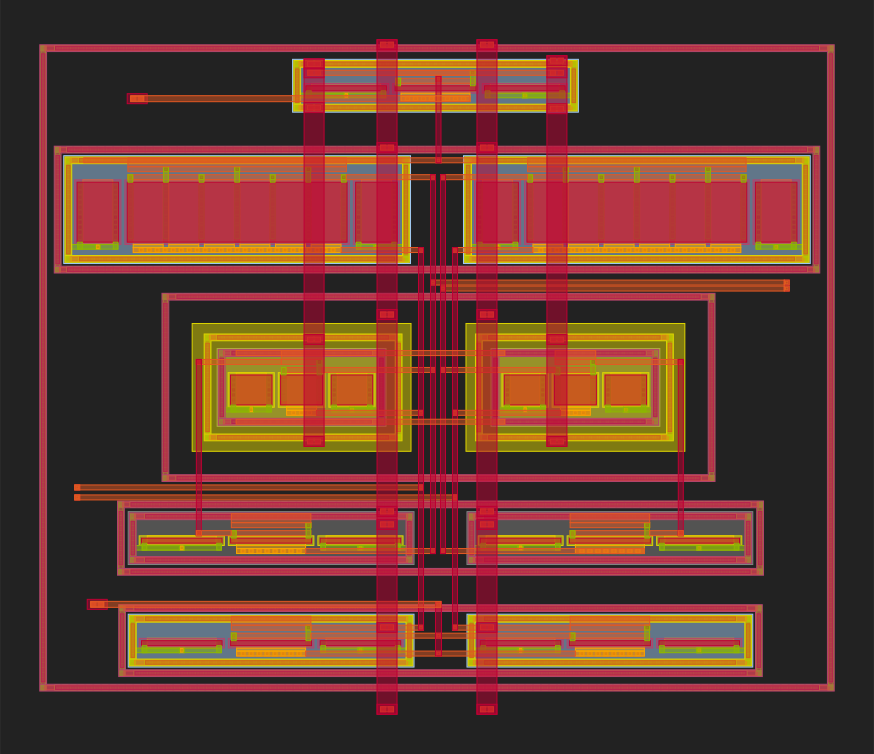

In [2]:
# VDD LEFT SIDE WAY
VDD1_a_via = ALL_TOP << viaarray
VDD2_via = ALL_TOP << viaarray
VDD3_via = ALL_TOP << viaarray
VDD4_via = ALL_TOP << viaarray
VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)

# VIA ARRAY TO SOURCE BIAS REF
bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
via_ref_vdd_bias = VDD1_a_via.center
VDD1_b_via = ALL_TOP << viaarray
VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
#ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
VDD1_c_via = ALL_TOP << viaarray
VDD1_c_via.move((32, bias_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])

# VDD RIGHT SIDE WAY **
VDD5_via = ALL_TOP << viaarray
VDD6_via = ALL_TOP << viaarray
VDD7_via = ALL_TOP << viaarray
VDD8_via = ALL_TOP << viaarray
VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)

# ---- ROUTE VDD
route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_L
route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_R

# VSS LEFT SIDE WAY
VSS1_via = ALL_TOP << viaarray
VSS2_via = ALL_TOP << viaarray
VSS3_via = ALL_TOP << viaarray
VSS4_via = ALL_TOP << viaarray
VSS5_via = ALL_TOP << viaarray
VSS6_via = ALL_TOP << viaarray
VSS7_via = ALL_TOP << viaarray
VSS1_via.movex(15).movey(16.5)
VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
VSS7_via.movex(VSS1_via.center[0]).movey(-50)

# ---- ROUTE VSS LEFT
route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_L

# VSS RIGHT SIDE WAY
VSS8_via = ALL_TOP << viaarray
VSS9_via = ALL_TOP << viaarray
VSS10_via = ALL_TOP << viaarray
VSS11_via = ALL_TOP << viaarray
VSS12_via = ALL_TOP << viaarray
VSS13_via = ALL_TOP << viaarray
VSS14_via = ALL_TOP << viaarray
VSS8_via.movex(25).movey(16.5)
VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
VSS14_via.movex(VSS8_via.center[0]).movey(-50)

# ---- ROUTE VSS RIGHT
route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_R

display_component(ALL_TOP, scale =1,path="../../")

2025-11-05 06:15:20.941 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'INA11.gds'


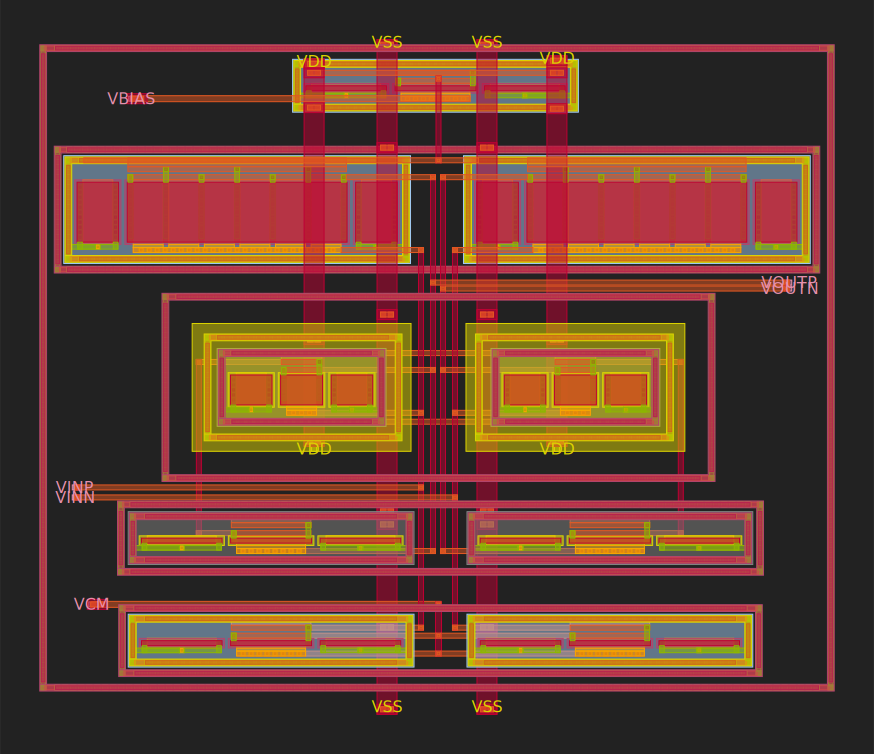

2025-11-05 06:15:29.453 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmp087_9xul/INA11.gds'


using default pdk_root: /usr/bin/miniconda3/share/pdk/
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmp087_9xul/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "INA11".
[INFO]: Loading INA11

Loadi

In [3]:
##########################################################################################################
# PORT FOR PAD
##########################################################################################################
ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")

ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")

ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")

component = component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))
## To see all Ports
#component.pprint_ports()

##########################################################################################################
# LABELLING
##########################################################################################################
# VSS 
psize=(0.5,0.5)
move_info = list()
vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["VSS_TOPL_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOML_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_TOPR_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOMR_top_met_N"],None))
#vss_ref= ALL_TOP << vsslabel

#VDD
vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["VDD_TOPL_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_TOPR_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOML_top_met_S"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOMR_top_met_S"],None))
#vdd_ref = ALL_TOP << vddlabel

# output
outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputplabel,component.ports["OUTP_top_met_E"],None))
outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputnlabel,component.ports["OUTN_top_met_E"],None))
#output_ref = ALL_TOP << outputplabel

# input
inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
#input_ref = ALL_TOP << inputplabel

# Vbias label
vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
vbiaslabel_ref = align_comp_to_port(vbiaslabel, component.ports["VBIAS_top_met_W"], alignment=('c','c'))
vbiaslabel_ref.movex(0.4)
ALL_TOP.add(vbiaslabel_ref)
#vbias_ref = ALL_TOP << vbiaslabel

# VCM label
vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
vcmlabel_ref = align_comp_to_port(vcmlabel, component.ports["VCM_top_met_W"], alignment=('c','c'))
vcmlabel_ref.movex(0.4)
ALL_TOP.add(vcmlabel_ref)
#vcm_ref = ALL_TOP << vcmlabel

##########################################################################################################
# DISPLAY AND DRC SECTION
##########################################################################################################
for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        ALL_TOP.add(compref)
component = ALL_TOP.flatten()

#component.show()
component.name = "INA11"
component.write_gds("INA11.gds")
display_component(component, scale =1,path="../../")
drc_result = gf180.drc_magic(component, "INA11")

In [4]:
ina_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INA"))

def add_ina_labels(
    ina_in: Component,
    pdk: gf180
    ) -> Component:
    
    ina_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPL_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOML_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPR_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOMR_top_met_N"],None))
    
    #VDD
    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPL_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPR_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOML_top_met_S"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOMR_top_met_S"],None))
    
    # output
    outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputplabel,ina_in.ports["OUTP_top_met_E"],None))
    outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputnlabel,ina_in.ports["OUTN_top_met_E"],None))
    
    # input
    inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputplabel,ina_in.ports["INP_top_met_W"], None))
    inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputnlabel,ina_in.ports["INN_top_met_W"], None))
    
    # Vbias label
    vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vbiaslabel,ina_in.ports["VBIAS_top_met_W"], None))
    
    # VCM label
    vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vcmlabel,ina_in.ports["VCM_top_met_W"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            ina_in.add(compref)
    return ina_in.flatten()
    
def ina(
        pdk: gf180
        ) -> Component:

    pdk.activate()

    nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
    }
    pmos_kwargs = {
        "with_tie": True,
        "dnwell": False,
        "sd_route_topmet": "met2",
        "gate_route_topmet": "met2",
        "sd_route_left": True,
        "rmult": None,
        "gate_rmult": 1,
        "interfinger_rmult": 1,
        "substrate_tap_layers": ("met2","met1"),
        "dummy_routes": True
    }
    
    # DISTANCE FOR SHIFTING (FREELY)
    x_distance = 5 #jarak horizontal antar komponen
    y_distance = 5 #jarak vertikal antar komponen
    
    #########################################################
    # - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    pmos_input_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (6,6), # width of the input fet and feedback fet respectively.
            "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_input_config["pdk"]
    width=pmos_input_config["width"]
    length=pmos_input_config["length"]
    fingers=pmos_input_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_input_config["dummy_1"]
    dummy_2=pmos_input_config["dummy_2"]
    tie_layers1=pmos_input_config["tie_layers1"]
    tie_layers2=pmos_input_config["tie_layers2"]
    sd_rmult=pmos_input_config["sd_rmult"]
    
    pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    
    top_level = Component("PMOS_PAIR_BIAS")
    pfet1_ref = top_level << pfet1
    pfet2_ref = top_level << pfet2
    
    pfet1_ref.name = "PFET1"
    pfet2_ref.name = "PFET2"
    
    placement = pmos_input_config["placement"]
    
    #Global Variable
    compSep = gf180.util_max_metal_seperation() #rule dari gf180
    padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180
    
    if placement == "horizontal":
        pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")  
    
    # For TAP RING for PMOS PAIR only
    flattened_top = top_level.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

    #########################################################
    # - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
    ########################################################
    pmos_bias_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_bias_config["pdk"]
    width=pmos_bias_config["width"]
    length=pmos_bias_config["length"]
    fingers=pmos_bias_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_bias_config["dummy_1"]
    dummy_2=pmos_bias_config["dummy_2"]
    tie_layers1=pmos_bias_config["tie_layers1"]
    tie_layers2=pmos_bias_config["tie_layers2"]
    sd_rmult=pmos_bias_config["sd_rmult"]
    
    bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    bias_ref = top_level << bias_pmos
    bias_ref.name = "PFET_Bias"
    bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)
    
    #########################################################
    # - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    nmos_input_config = {
            "pdk1": gf180,  # PDK to use
            "placement1": "horizontal",  # can be "horizontal" or "vertical"
            "width1": (3, 3),  # width of the input fet and feedback fet respectively
            "length1": (3, 3),  # length of the input fet and feedback fet respectively
            "fingers1": (1, 1),  # number of fingers for each device
            "multipliers1": (1, 1),  # multipliers for each device
            "dummy_11": (True, True),  # dummies for input fet (left, right)
            "dummy_21": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult1": 1,  # thickness of the sd metal layer
    }
    
    # Activate PDK for NMOS input stage
    pdk = nmos_input_config["pdk1"]
    #pdk.activate()
    
    # Extract parameters from PMOS input config
    width       = nmos_input_config["width1"]
    length      = nmos_input_config["length1"]
    fingers     = nmos_input_config["fingers1"]
    multipliers = nmos_input_config["multipliers1"]
    
    dummy_1     = nmos_input_config["dummy_11"]
    dummy_2     = nmos_input_config["dummy_21"]
    tie_layers1 = nmos_input_config["tie_layers11"]
    tie_layers2 = nmos_input_config["tie_layers21"]
    sd_rmult    = nmos_input_config["sd_rmult1"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
    # Buat pasangan NMOS
    nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level1 = Component("NMOS_INPUT_PAIR")
    nfet1_ref = top_level1 << nfet1
    nfet2_ref = top_level1 << nfet2
    nfet1_ref.name = "NFET1"
    nfet2_ref.name = "NFET2"
    nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Additional Tap Ring for Deep N-Well
    dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
    dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
    tring_ref1 = top_level1 << dnwell_tapring_nfet1
    tring_ref2 = top_level1 << dnwell_tapring_nfet2
    tring_ref1.name = "tring_ref1_pmos"
    tring_ref2.name = "tring_ref2_pmos"
    tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    #tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Placement
    placement = nmos_input_config["placement1"]
    shift_amount =  -prec_center(nfet1_ref)[0]
    if placement == "horizontal":
        nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
        tring_ref1.movex(destination=shift_amount)
        tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ###############################################################
    # - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
    ###############################################################
    nmos_current_mirror_config = {
            "pdk2": gf180,  # PDK to use
            "placement2": "horizontal",  # can be "horizontal" or "vertical"
            "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
            "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
            "fingers2": (1, 1),  # number of fingers for each device
            "multipliers2": (1, 1),  # multipliers for each device
            "dummy_12": (True, True),  # dummies for input fet (left, right)
            "dummy_22": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult2": 1,  # thickness of the sd metal layer
    }
    # Activate PDK for NMOS Mirror Pair
    pdk = nmos_current_mirror_config["pdk2"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = nmos_current_mirror_config["width2"]
    length      = nmos_current_mirror_config["length2"]
    fingers     = nmos_current_mirror_config["fingers2"]
    multipliers = nmos_current_mirror_config["multipliers2"]
    dummy_1     = nmos_current_mirror_config["dummy_12"]
    dummy_2     = nmos_current_mirror_config["dummy_22"]
    tie_layers1 = nmos_current_mirror_config["tie_layers12"]
    tie_layers2 = nmos_current_mirror_config["tie_layers22"]
    sd_rmult    = nmos_current_mirror_config["sd_rmult2"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
    # Buat pasangan NMOS
    nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level2 = Component("NMOS_MIRROR")
    #top_level2 = Component(name="NMOS_Mirror_Pair")
    nfet3_ref = top_level2 << nfet3
    nfet4_ref = top_level2 << nfet4
    nfet3_ref.name = "NFET3"
    nfet4_ref.name = "NFET4"
    nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement
    placement = nmos_current_mirror_config["placement2"]
    if placement == "horizontal":
        nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
        
    #########################################################
    # - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
    #########################################################
    pmos_diodes_connected_config={
            "pdk3": gf180, # pdk to use
            "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_13": (True,True), # dummy pattern for input fet (left,right)
            "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult3":1, # thickness of the sd metal layer.
    }
    # Activate PDK for PMOS input stage
    pdk = pmos_diodes_connected_config["pdk3"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = pmos_diodes_connected_config["width3"]
    length      = pmos_diodes_connected_config["length3"]
    fingers     = pmos_diodes_connected_config["fingers3"]
    multipliers = pmos_diodes_connected_config["multipliers3"]
    dummy_1     = pmos_diodes_connected_config["dummy_13"]
    dummy_2     = pmos_diodes_connected_config["dummy_23"]
    tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
    tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
    sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
    # PMOS-DIODE Pair
    pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    
    # Top level component
    top_level3 = Component("PMOS_DIODE_PAIR")
    pfet3_ref = top_level3 << pfet3
    pfet4_ref = top_level3 << pfet4
    pfet3_ref.name = "PFET3"
    pfet4_ref.name = "PFET4"
    pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement (horizontal)
    placement = pmos_diodes_connected_config["placement3"]
    if placement == "horizontal":
        pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ############################################################################################
    # TOP LEVEL DECLARATION IN 1 DISPLAY
    ###########################################################################################
    ALL_TOP = Component("ALL_TOP")
    
    # PMOS BIAS + PMOS PAIR 
    pmos_ref = ALL_TOP << top_level
    pmos_ref.name = "PMOS_BIAS"
    pmos_ref.movex(0)   
    pmos_ref.movey(0)
    
    # NMOS PAIR
    nmos_ref = ALL_TOP << top_level1
    nmos_ref.name = "NMOS_Inp_Pair"
    flattened_top = top_level1.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level1 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)
    
    # NMOS CURRENT MIRROR
    cm_ref = ALL_TOP << top_level2
    cm_ref.name = "NMOS_Mirror_Pair"
    flattened_top = top_level2.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level2 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    
    # FOR PMOS DIODE CONNECTED
    pmos_diode_ref = ALL_TOP << top_level3
    pmos_diode_ref.name = "PMOS_Diode_Pair"
    flattened_top = top_level3.flatten()
    
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level3 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

    ALL_TOP.info["pmos_pair"] = top_level
    ALL_TOP.info["nmos_pair"] = top_level1
    
    ###########################################################################################################
    # FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
    ###########################################################################################################
    flattened_top = ALL_TOP.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = ALL_TOP << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    
    ##########################################################################################################
    # VIA AND ROUTING INA
    ##########################################################################################################
    # --- VIA DEF ---
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3
    
    # --- VIA INPUT ---
    # -- IN +
    via_input_P = ALL_TOP << viam2m3
    via_input_P.movex(-16).movey(-27.5)
    via_to_input_P = ALL_TOP << viam2m3
    via_to_input_P.movex(18.4).movey(-27.5)
    # -- IN - 
    via_input_N = ALL_TOP << viam2m3
    via_input_N.movex(-16).movey(-28.5)
    via_to_input_N = ALL_TOP << viam2m3
    via_to_input_N.movex(21.8).movey(-28.5)
    
    # --- VIA OUTPUT ---
    # --- OUTPUT P
    via_to_output_P = ALL_TOP << viam2m3
    via_output_P = ALL_TOP << viam2m3
    via_to_output_P.movex(19.6).movey(-7.5)
    via_output_P.movex(55).movey(-7.5)
    via_to_output_P_center = via_to_output_P.center
    
    # --- OUTPUT N
    via_output_N = ALL_TOP << viam2m3
    via_output_N.movex(55).movey(-8.5)
    via_to_output_N = ALL_TOP << viam2m3
    via_to_output_N.movex(20.6).movey(-8.5)
    
    # --- ROUTING (Vertical on M3) ---
    # SYNTAX FULL EXAMPLE (use if needed only :))
    #route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
    #route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
    route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
    route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_out_P
    ALL_TOP << route_hori_out_N
    route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
    route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_in_P
    ALL_TOP << route_hori_in_N
    
    # --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
    pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])
    
    pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
    pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center
    via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])
    
    pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center
    via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_L --- LEFT SIDE
    nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])
    
    nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
    nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])
    
    nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_L --- LEFT SIDE
    nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_R --- RIGHT SIDE
    nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])
    
    # ROUTE FOR OUTPUT
    route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
    ALL_TOP << route_vertical_out_P
    route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
    ALL_TOP << route_vertical_out_N
    
    # ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
    # LEFT
    pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
    # RIGHT
    pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])
    
    # ROUTE FOR INPUT
    route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
    ALL_TOP << route_vertical_in_P
    route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
    ALL_TOP << route_vertical_in_N
    
    # ROUTING C ROUTE
    #ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
    #ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
    # top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    # CROUTE WITH EXTENSION FOOT
    ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
    ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))
    
    # VIA FOR VCM WAY
    viaarray = via_array(pdk, "met2", "met3", (2,1))
    VCM_via = ALL_TOP << viaarray
    VCM_via.movex(-14).movey(-39.5)
    via_to_vcm = ALL_TOP << viam2m3
    via_to_vcm.movex(20.15).movey(-39.5)
    #print(VCM_via.ports.keys())
    
    # CENTER FOR Via to VCM
    pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
    via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])
    
    pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
    via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])
    
    # ROUTE VERTICAL VCM
    route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
    ALL_TOP << route_vertical_VCM
    # ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
    route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
    ALL_TOP << route_hori_VCM
    
    # TIE PAIR
    # -- NMOS
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
    # SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
    via_source_pmos_bias = ALL_TOP << viam2m3
    via_source_pmos_bias.movex(20.15).movey(13.1)
    # -- PMOS
    pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
    via_ref_conn_tie = via_source_pmos_bias.center
    via_conn_tie = ALL_TOP << viam2m3
    via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
    pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
    ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
    # Route PMOS BIAS to SOURCE
    route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
    ALL_TOP << route_vertical_bias_to_source
    
    # VIA FOR VBIAS
    bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
    Vbias_via = ALL_TOP << viaarray
    Vbias_via.movex(-10).movey((bias_src_port.center[1]))
    ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)
    
    # TIE D/S
    ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])
    
    # VDD LEFT SIDE WAY
    VDD1_a_via = ALL_TOP << viaarray
    VDD2_via = ALL_TOP << viaarray
    VDD3_via = ALL_TOP << viaarray
    VDD4_via = ALL_TOP << viaarray
    VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
    VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
    VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
    VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)
    
    # VIA ARRAY TO SOURCE BIAS REF
    bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
    via_ref_vdd_bias = VDD1_a_via.center
    VDD1_b_via = ALL_TOP << viaarray
    VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
    #ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
    VDD1_c_via = ALL_TOP << viaarray
    VDD1_c_via.move((32, bias_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])
    
    # VDD RIGHT SIDE WAY **
    VDD5_via = ALL_TOP << viaarray
    VDD6_via = ALL_TOP << viaarray
    VDD7_via = ALL_TOP << viaarray
    VDD8_via = ALL_TOP << viaarray
    VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
    VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
    VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
    VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)
    
    # ---- ROUTE VDD
    route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_L
    route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_R
    
    # VSS LEFT SIDE WAY
    VSS1_via = ALL_TOP << viaarray
    VSS2_via = ALL_TOP << viaarray
    VSS3_via = ALL_TOP << viaarray
    VSS4_via = ALL_TOP << viaarray
    VSS5_via = ALL_TOP << viaarray
    VSS6_via = ALL_TOP << viaarray
    VSS7_via = ALL_TOP << viaarray
    VSS1_via.movex(15).movey(16.5)
    VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
    VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
    VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
    VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
    VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
    VSS7_via.movex(VSS1_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS LEFT
    route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_L
    
    # VSS RIGHT SIDE WAY
    VSS8_via = ALL_TOP << viaarray
    VSS9_via = ALL_TOP << viaarray
    VSS10_via = ALL_TOP << viaarray
    VSS11_via = ALL_TOP << viaarray
    VSS12_via = ALL_TOP << viaarray
    VSS13_via = ALL_TOP << viaarray
    VSS14_via = ALL_TOP << viaarray
    VSS8_via.movex(25).movey(16.5)
    VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
    VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
    VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
    VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
    VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
    VSS14_via.movex(VSS8_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS RIGHT
    route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_R
    
    ##########################################################################################################
    # PORT FOR PAD
    ##########################################################################################################
    ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
    ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
    ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
    ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")
    
    ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
    ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
    ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
    ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")
    
    ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
    ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
    ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
    ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")
    
    ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
    ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")
    
    return component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

if __name__ == "__main__":
\tcomp = ina(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_ina_labels(comp, gf180)\n
\tcomp.name = "INA"\n
\tcomp.write_gds('out_INA.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "INA")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCH import cswitch,add_cswitch_labels

__all__ = [
    'cswitch',
    'add_cswitch_labels',
] 
"""

directory = "../../INA/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_INA.py", "w") as file:
    file.write(ina_code_string)

2025-09-10 12:51:32.968 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active
2025-09-10 12:51:51.017 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'INA11.gds'


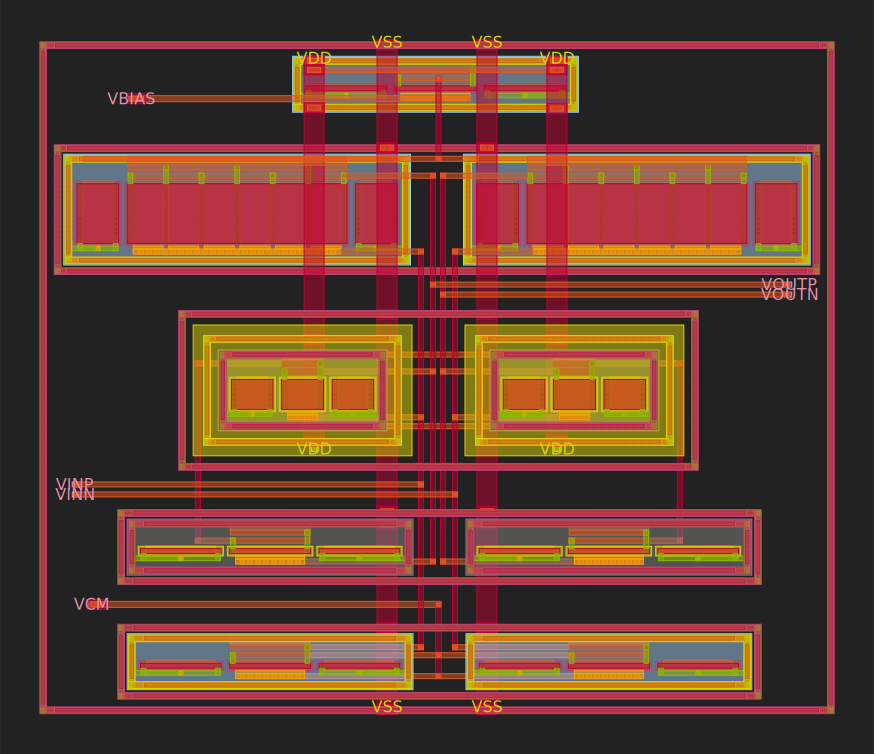

2025-09-10 12:51:51.524 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmp4ona8_eq/INA11.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmp4ona8_eq/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "INA11".
[INFO]: Loading INA11

Loading DRC CIF style.
No errors foun

In [1]:
## Activate if necessary to install following packages

# !pip install svgutils
# !pip install ipywidgets

############################################################
# IMPORT FROM LIB, DECLARE FUNC, ETC.
############################################################
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout import via_stack, via_array

############################################################
# DEFINITION OF NMOS/PMOS
############################################################
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}
pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

# DISTANCE FOR SHIFTING (FREELY)
x_distance = 5 #jarak horizontal antar komponen
y_distance = 5 #jarak vertikal antar komponen

#########################################################
# - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
########################################################
pmos_input_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (6,6), # width of the input fet and feedback fet respectively.
        "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_input_config["pdk"]
pdk.activate()
width=pmos_input_config["width"]
length=pmos_input_config["length"]
fingers=pmos_input_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_input_config["dummy_1"]
dummy_2=pmos_input_config["dummy_2"]
tie_layers1=pmos_input_config["tie_layers1"]
tie_layers2=pmos_input_config["tie_layers2"]
sd_rmult=pmos_input_config["sd_rmult"]

pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )

top_level = Component("PMOS_PAIR_BIAS")
pfet1_ref = top_level << pfet1
pfet2_ref = top_level << pfet2

pfet1_ref.name = "PFET1"
pfet2_ref.name = "PFET2"

placement = pmos_input_config["placement"]

#Global Variable
compSep = gf180.util_max_metal_seperation() #rule dari gf180
padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180

if placement == "horizontal":
    pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")  

# For TAP RING for PMOS PAIR only
flattened_top = top_level.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

#########################################################
# - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
########################################################
pmos_bias_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_bias_config["pdk"]
width=pmos_bias_config["width"]
length=pmos_bias_config["length"]
fingers=pmos_bias_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_bias_config["dummy_1"]
dummy_2=pmos_bias_config["dummy_2"]
tie_layers1=pmos_bias_config["tie_layers1"]
tie_layers2=pmos_bias_config["tie_layers2"]
sd_rmult=pmos_bias_config["sd_rmult"]

bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
bias_ref = top_level << bias_pmos
bias_ref.name = "PFET_Bias"
bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)

#########################################################
# - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
########################################################
nmos_input_config = {
        "pdk1": gf180,  # PDK to use
        "placement1": "horizontal",  # can be "horizontal" or "vertical"
        "width1": (3, 3),  # width of the input fet and feedback fet respectively
        "length1": (3, 3),  # length of the input fet and feedback fet respectively
        "fingers1": (1, 1),  # number of fingers for each device
        "multipliers1": (1, 1),  # multipliers for each device
        "dummy_11": (True, True),  # dummies for input fet (left, right)
        "dummy_21": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult1": 1,  # thickness of the sd metal layer
}

# Activate PDK for NMOS input stage
pdk = nmos_input_config["pdk1"]
#pdk.activate()

# Extract parameters from PMOS input config
width       = nmos_input_config["width1"]
length      = nmos_input_config["length1"]
fingers     = nmos_input_config["fingers1"]
multipliers = nmos_input_config["multipliers1"]

dummy_1     = nmos_input_config["dummy_11"]
dummy_2     = nmos_input_config["dummy_21"]
tie_layers1 = nmos_input_config["tie_layers11"]
tie_layers2 = nmos_input_config["tie_layers21"]
sd_rmult    = nmos_input_config["sd_rmult1"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
# Buat pasangan NMOS
nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level1 = Component("NMOS_INPUT_PAIR")
nfet1_ref = top_level1 << nfet1
nfet2_ref = top_level1 << nfet2
nfet1_ref.name = "NFET1"
nfet2_ref.name = "NFET2"
nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Additional Tap Ring for Deep N-Well
dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
tring_ref1 = top_level1 << dnwell_tapring_nfet1
tring_ref2 = top_level1 << dnwell_tapring_nfet2
tring_ref1.name = "tring_ref1_pmos"
tring_ref2.name = "tring_ref2_pmos"
tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
#tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Placement
placement = nmos_input_config["placement1"]
shift_amount =  -prec_center(nfet1_ref)[0]
if placement == "horizontal":
    nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
    tring_ref1.movex(destination=shift_amount)
    tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
###############################################################
# - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
###############################################################
nmos_current_mirror_config = {
        "pdk2": gf180,  # PDK to use
        "placement2": "horizontal",  # can be "horizontal" or "vertical"
        "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
        "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
        "fingers2": (1, 1),  # number of fingers for each device
        "multipliers2": (1, 1),  # multipliers for each device
        "dummy_12": (True, True),  # dummies for input fet (left, right)
        "dummy_22": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult2": 1,  # thickness of the sd metal layer
}
# Activate PDK for NMOS Mirror Pair
pdk = nmos_current_mirror_config["pdk2"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = nmos_current_mirror_config["width2"]
length      = nmos_current_mirror_config["length2"]
fingers     = nmos_current_mirror_config["fingers2"]
multipliers = nmos_current_mirror_config["multipliers2"]
dummy_1     = nmos_current_mirror_config["dummy_12"]
dummy_2     = nmos_current_mirror_config["dummy_22"]
tie_layers1 = nmos_current_mirror_config["tie_layers12"]
tie_layers2 = nmos_current_mirror_config["tie_layers22"]
sd_rmult    = nmos_current_mirror_config["sd_rmult2"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
# Buat pasangan NMOS
nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level2 = Component("NMOS_MIRROR")
#top_level2 = Component(name="NMOS_Mirror_Pair")
nfet3_ref = top_level2 << nfet3
nfet4_ref = top_level2 << nfet4
nfet3_ref.name = "NFET3"
nfet4_ref.name = "NFET4"
nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement
placement = nmos_current_mirror_config["placement2"]
if placement == "horizontal":
    nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
#########################################################
# - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
#########################################################
pmos_diodes_connected_config={
        "pdk3": gf180, # pdk to use
        "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_13": (True,True), # dummy pattern for input fet (left,right)
        "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult3":1, # thickness of the sd metal layer.
}
# Activate PDK for PMOS input stage
pdk = pmos_diodes_connected_config["pdk3"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = pmos_diodes_connected_config["width3"]
length      = pmos_diodes_connected_config["length3"]
fingers     = pmos_diodes_connected_config["fingers3"]
multipliers = pmos_diodes_connected_config["multipliers3"]
dummy_1     = pmos_diodes_connected_config["dummy_13"]
dummy_2     = pmos_diodes_connected_config["dummy_23"]
tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
# PMOS-DIODE Pair
pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)

# Top level component
top_level3 = Component("PMOS_DIODE_PAIR")
pfet3_ref = top_level3 << pfet3
pfet4_ref = top_level3 << pfet4
pfet3_ref.name = "PFET3"
pfet4_ref.name = "PFET4"
pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement (horizontal)
placement = pmos_diodes_connected_config["placement3"]
if placement == "horizontal":
    pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")

############################################################################################
# TOP LEVEL DECLARATION IN 1 DISPLAY
###########################################################################################
ALL_TOP = Component("ALL_TOP")

# PMOS BIAS + PMOS PAIR 
pmos_ref = ALL_TOP << top_level
pmos_ref.name = "PMOS_BIAS"
pmos_ref.movex(0)   
pmos_ref.movey(0)

# NMOS PAIR
nmos_ref = ALL_TOP << top_level1
nmos_ref.name = "NMOS_Inp_Pair"
flattened_top = top_level1.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level1 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)

# NMOS CURRENT MIRROR
cm_ref = ALL_TOP << top_level2
cm_ref.name = "NMOS_Mirror_Pair"
flattened_top = top_level2.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level2 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)

# FOR PMOS DIODE CONNECTED
pmos_diode_ref = ALL_TOP << top_level3
pmos_diode_ref.name = "PMOS_Diode_Pair"
flattened_top = top_level3.flatten()

tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level3 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

###########################################################################################################
# FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
###########################################################################################################
flattened_top = ALL_TOP.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = ALL_TOP << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

##########################################################################################################
# VIA AND ROUTING INA
##########################################################################################################
# --- VIA DEF ---
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3

# --- VIA INPUT ---
# -- IN +
via_input_P = ALL_TOP << viam2m3
via_input_P.movex(-16).movey(-27.5)
via_to_input_P = ALL_TOP << viam2m3
via_to_input_P.movex(18.4).movey(-27.5)
# -- IN - 
via_input_N = ALL_TOP << viam2m3
via_input_N.movex(-16).movey(-28.5)
via_to_input_N = ALL_TOP << viam2m3
via_to_input_N.movex(21.8).movey(-28.5)

# --- VIA OUTPUT ---
# --- OUTPUT P
via_to_output_P = ALL_TOP << viam2m3
via_output_P = ALL_TOP << viam2m3
via_to_output_P.movex(19.6).movey(-7.5)
via_output_P.movex(55).movey(-7.5)
via_to_output_P_center = via_to_output_P.center

# --- OUTPUT N
via_output_N = ALL_TOP << viam2m3
via_output_N.movex(55).movey(-8.5)
via_to_output_N = ALL_TOP << viam2m3
via_to_output_N.movex(20.6).movey(-8.5)

# --- ROUTING (Vertical on M3) ---
# SYNTAX FULL EXAMPLE (use if needed only :))
#route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
#route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
ALL_TOP << route_hori_out_P
ALL_TOP << route_hori_out_N
route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
ALL_TOP << route_hori_in_P
ALL_TOP << route_hori_in_N

# --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])

pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center
via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])

pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center
via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_L --- LEFT SIDE
nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])

nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])

nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_L --- LEFT SIDE
nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_R --- RIGHT SIDE
nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])

# ROUTE FOR OUTPUT
route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
ALL_TOP << route_vertical_out_P
route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
ALL_TOP << route_vertical_out_N

# ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
# LEFT
pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
# RIGHT
pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])

# ROUTE FOR INPUT
route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
ALL_TOP << route_vertical_in_P
route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
ALL_TOP << route_vertical_in_N

# ROUTING C ROUTE
#ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
#ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
# top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
# CROUTE WITH EXTENSION FOOT
ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))

# VIA FOR VCM WAY
viaarray = via_array(pdk, "met2", "met3", (2,1))
VCM_via = ALL_TOP << viaarray
VCM_via.movex(-14).movey(-39.5)
via_to_vcm = ALL_TOP << viam2m3
via_to_vcm.movex(20.15).movey(-39.5)
#print(VCM_via.ports.keys())

# CENTER FOR Via to VCM
pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])

pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])

# ROUTE VERTICAL VCM
route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
ALL_TOP << route_vertical_VCM
# ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
ALL_TOP << route_hori_VCM

# TIE PAIR
# -- NMOS
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
# SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
via_source_pmos_bias = ALL_TOP << viam2m3
via_source_pmos_bias.movex(20.15).movey(13.1)
# -- PMOS
pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
via_ref_conn_tie = via_source_pmos_bias.center
via_conn_tie = ALL_TOP << viam2m3
via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
# Route PMOS BIAS to SOURCE
route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
ALL_TOP << route_vertical_bias_to_source

# VIA FOR VBIAS
bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
Vbias_via = ALL_TOP << viaarray
Vbias_via.movex(-10).movey((bias_src_port.center[1]))
ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)

# TIE D/S
ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])

# VDD LEFT SIDE WAY
VDD1_a_via = ALL_TOP << viaarray
VDD2_via = ALL_TOP << viaarray
VDD3_via = ALL_TOP << viaarray
VDD4_via = ALL_TOP << viaarray
VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)

# VIA ARRAY TO SOURCE BIAS REF
bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
via_ref_vdd_bias = VDD1_a_via.center
VDD1_b_via = ALL_TOP << viaarray
VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
#ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
VDD1_c_via = ALL_TOP << viaarray
VDD1_c_via.move((32, bias_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])

# VDD RIGHT SIDE WAY **
VDD5_via = ALL_TOP << viaarray
VDD6_via = ALL_TOP << viaarray
VDD7_via = ALL_TOP << viaarray
VDD8_via = ALL_TOP << viaarray
VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)

# ---- ROUTE VDD
route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_L
route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_R

# VSS LEFT SIDE WAY
VSS1_via = ALL_TOP << viaarray
VSS2_via = ALL_TOP << viaarray
VSS3_via = ALL_TOP << viaarray
VSS4_via = ALL_TOP << viaarray
VSS5_via = ALL_TOP << viaarray
VSS6_via = ALL_TOP << viaarray
VSS7_via = ALL_TOP << viaarray
VSS1_via.movex(15).movey(16.5)
VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
VSS7_via.movex(VSS1_via.center[0]).movey(-50)

# ---- ROUTE VSS LEFT
route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_L

# VSS RIGHT SIDE WAY
VSS8_via = ALL_TOP << viaarray
VSS9_via = ALL_TOP << viaarray
VSS10_via = ALL_TOP << viaarray
VSS11_via = ALL_TOP << viaarray
VSS12_via = ALL_TOP << viaarray
VSS13_via = ALL_TOP << viaarray
VSS14_via = ALL_TOP << viaarray
VSS8_via.movex(25).movey(16.5)
VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
VSS14_via.movex(VSS8_via.center[0]).movey(-50)

# ---- ROUTE VSS RIGHT
route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_R

##########################################################################################################
# PORT FOR PAD
##########################################################################################################
ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")

ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")

ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")

component = component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

## To see all Ports
#component.pprint_ports()

##########################################################################################################
# LABELLING
##########################################################################################################
# VSS 
psize=(0.5,0.5)
move_info = list()
vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["VSS_TOPL_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOML_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_TOPR_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOMR_top_met_N"],None))
#vss_ref= ALL_TOP << vsslabel

#VDD
vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["VDD_TOPL_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_TOPR_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOML_top_met_S"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOMR_top_met_S"],None))
#vdd_ref = ALL_TOP << vddlabel

# output
outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputplabel,component.ports["OUTP_top_met_E"],None))
outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputnlabel,component.ports["OUTN_top_met_E"],None))
#output_ref = ALL_TOP << outputplabel

# input
inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
#input_ref = ALL_TOP << inputplabel

# Vbias label
vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
vbiaslabel_ref = align_comp_to_port(vbiaslabel, component.ports["VBIAS_top_met_W"], alignment=('c','c'))
vbiaslabel_ref.movex(0.4)
ALL_TOP.add(vbiaslabel_ref)
#vbias_ref = ALL_TOP << vbiaslabel

# VCM label
vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
vcmlabel_ref = align_comp_to_port(vcmlabel, component.ports["VCM_top_met_W"], alignment=('c','c'))
vcmlabel_ref.movex(0.4)
ALL_TOP.add(vcmlabel_ref)
#vcm_ref = ALL_TOP << vcmlabel
##########################################################################################################
# DISPLAY AND DRC SECTION
##########################################################################################################
for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        ALL_TOP.add(compref)
component = ALL_TOP.flatten()

#component.show()
component.name = "INA11"
component.write_gds("INA11.gds")
display_component(component, scale =1,path="../../")
drc_result = gf180.drc_magic(component, "INA11")

In [3]:
ina_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INA"))

def add_ina_labels(
    ina_in: Component,
    pdk: gf180
    ) -> Component:
    
    ina_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPL_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOML_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPR_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOMR_top_met_N"],None))
    
    #VDD
    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPL_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPR_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOML_top_met_S"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOMR_top_met_S"],None))
    
    # output
    outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputplabel,ina_in.ports["OUTP_top_met_E"],None))
    outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputnlabel,ina_in.ports["OUTN_top_met_E"],None))
    
    # input
    inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputplabel,ina_in.ports["INP_top_met_W"], None))
    inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputnlabel,ina_in.ports["INN_top_met_W"], None))
    
    # Vbias label
    vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vbiaslabel,ina_in.ports["VBIAS_top_met_W"], None))
    
    # VCM label
    vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vcmlabel,ina_in.ports["VCM_top_met_W"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            ina_in.add(compref)
    return ina_in.flatten()
    
def ina(
        pdk: gf180
        ) -> Component:

    pdk.activate()

    nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
    }
    pmos_kwargs = {
        "with_tie": True,
        "dnwell": False,
        "sd_route_topmet": "met2",
        "gate_route_topmet": "met2",
        "sd_route_left": True,
        "rmult": None,
        "gate_rmult": 1,
        "interfinger_rmult": 1,
        "substrate_tap_layers": ("met2","met1"),
        "dummy_routes": True
    }
    
    # DISTANCE FOR SHIFTING (FREELY)
    x_distance = 5 #jarak horizontal antar komponen
    y_distance = 5 #jarak vertikal antar komponen
    
    #########################################################
    # - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    pmos_input_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (6,6), # width of the input fet and feedback fet respectively.
            "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_input_config["pdk"]
    width=pmos_input_config["width"]
    length=pmos_input_config["length"]
    fingers=pmos_input_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_input_config["dummy_1"]
    dummy_2=pmos_input_config["dummy_2"]
    tie_layers1=pmos_input_config["tie_layers1"]
    tie_layers2=pmos_input_config["tie_layers2"]
    sd_rmult=pmos_input_config["sd_rmult"]
    
    pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    
    top_level = Component("PMOS_PAIR_BIAS")
    pfet1_ref = top_level << pfet1
    pfet2_ref = top_level << pfet2
    
    pfet1_ref.name = "PFET1"
    pfet2_ref.name = "PFET2"
    
    placement = pmos_input_config["placement"]
    
    #Global Variable
    compSep = gf180.util_max_metal_seperation() #rule dari gf180
    padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180
    
    if placement == "horizontal":
        pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")  
    
    # For TAP RING for PMOS PAIR only
    flattened_top = top_level.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

    #########################################################
    # - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
    ########################################################
    pmos_bias_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_bias_config["pdk"]
    width=pmos_bias_config["width"]
    length=pmos_bias_config["length"]
    fingers=pmos_bias_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_bias_config["dummy_1"]
    dummy_2=pmos_bias_config["dummy_2"]
    tie_layers1=pmos_bias_config["tie_layers1"]
    tie_layers2=pmos_bias_config["tie_layers2"]
    sd_rmult=pmos_bias_config["sd_rmult"]
    
    bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    bias_ref = top_level << bias_pmos
    bias_ref.name = "PFET_Bias"
    bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)
    
    #########################################################
    # - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    nmos_input_config = {
            "pdk1": gf180,  # PDK to use
            "placement1": "horizontal",  # can be "horizontal" or "vertical"
            "width1": (3, 3),  # width of the input fet and feedback fet respectively
            "length1": (3, 3),  # length of the input fet and feedback fet respectively
            "fingers1": (1, 1),  # number of fingers for each device
            "multipliers1": (1, 1),  # multipliers for each device
            "dummy_11": (True, True),  # dummies for input fet (left, right)
            "dummy_21": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult1": 1,  # thickness of the sd metal layer
    }
    
    # Activate PDK for NMOS input stage
    pdk = nmos_input_config["pdk1"]
    #pdk.activate()
    
    # Extract parameters from PMOS input config
    width       = nmos_input_config["width1"]
    length      = nmos_input_config["length1"]
    fingers     = nmos_input_config["fingers1"]
    multipliers = nmos_input_config["multipliers1"]
    
    dummy_1     = nmos_input_config["dummy_11"]
    dummy_2     = nmos_input_config["dummy_21"]
    tie_layers1 = nmos_input_config["tie_layers11"]
    tie_layers2 = nmos_input_config["tie_layers21"]
    sd_rmult    = nmos_input_config["sd_rmult1"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
    # Buat pasangan NMOS
    nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level1 = Component("NMOS_INPUT_PAIR")
    nfet1_ref = top_level1 << nfet1
    nfet2_ref = top_level1 << nfet2
    nfet1_ref.name = "NFET1"
    nfet2_ref.name = "NFET2"
    nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Additional Tap Ring for Deep N-Well
    dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
    dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
    tring_ref1 = top_level1 << dnwell_tapring_nfet1
    tring_ref2 = top_level1 << dnwell_tapring_nfet2
    tring_ref1.name = "tring_ref1_pmos"
    tring_ref2.name = "tring_ref2_pmos"
    tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    #tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Placement
    placement = nmos_input_config["placement1"]
    shift_amount =  -prec_center(nfet1_ref)[0]
    if placement == "horizontal":
        nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
        tring_ref1.movex(destination=shift_amount)
        tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ###############################################################
    # - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
    ###############################################################
    nmos_current_mirror_config = {
            "pdk2": gf180,  # PDK to use
            "placement2": "horizontal",  # can be "horizontal" or "vertical"
            "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
            "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
            "fingers2": (1, 1),  # number of fingers for each device
            "multipliers2": (1, 1),  # multipliers for each device
            "dummy_12": (True, True),  # dummies for input fet (left, right)
            "dummy_22": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult2": 1,  # thickness of the sd metal layer
    }
    # Activate PDK for NMOS Mirror Pair
    pdk = nmos_current_mirror_config["pdk2"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = nmos_current_mirror_config["width2"]
    length      = nmos_current_mirror_config["length2"]
    fingers     = nmos_current_mirror_config["fingers2"]
    multipliers = nmos_current_mirror_config["multipliers2"]
    dummy_1     = nmos_current_mirror_config["dummy_12"]
    dummy_2     = nmos_current_mirror_config["dummy_22"]
    tie_layers1 = nmos_current_mirror_config["tie_layers12"]
    tie_layers2 = nmos_current_mirror_config["tie_layers22"]
    sd_rmult    = nmos_current_mirror_config["sd_rmult2"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
    # Buat pasangan NMOS
    nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level2 = Component("NMOS_MIRROR")
    #top_level2 = Component(name="NMOS_Mirror_Pair")
    nfet3_ref = top_level2 << nfet3
    nfet4_ref = top_level2 << nfet4
    nfet3_ref.name = "NFET3"
    nfet4_ref.name = "NFET4"
    nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement
    placement = nmos_current_mirror_config["placement2"]
    if placement == "horizontal":
        nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
        
    #########################################################
    # - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
    #########################################################
    pmos_diodes_connected_config={
            "pdk3": gf180, # pdk to use
            "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_13": (True,True), # dummy pattern for input fet (left,right)
            "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult3":1, # thickness of the sd metal layer.
    }
    # Activate PDK for PMOS input stage
    pdk = pmos_diodes_connected_config["pdk3"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = pmos_diodes_connected_config["width3"]
    length      = pmos_diodes_connected_config["length3"]
    fingers     = pmos_diodes_connected_config["fingers3"]
    multipliers = pmos_diodes_connected_config["multipliers3"]
    dummy_1     = pmos_diodes_connected_config["dummy_13"]
    dummy_2     = pmos_diodes_connected_config["dummy_23"]
    tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
    tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
    sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
    # PMOS-DIODE Pair
    pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    
    # Top level component
    top_level3 = Component("PMOS_DIODE_PAIR")
    pfet3_ref = top_level3 << pfet3
    pfet4_ref = top_level3 << pfet4
    pfet3_ref.name = "PFET3"
    pfet4_ref.name = "PFET4"
    pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement (horizontal)
    placement = pmos_diodes_connected_config["placement3"]
    if placement == "horizontal":
        pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ############################################################################################
    # TOP LEVEL DECLARATION IN 1 DISPLAY
    ###########################################################################################
    ALL_TOP = Component("ALL_TOP")
    
    # PMOS BIAS + PMOS PAIR 
    pmos_ref = ALL_TOP << top_level
    pmos_ref.name = "PMOS_BIAS"
    pmos_ref.movex(0)   
    pmos_ref.movey(0)
    
    # NMOS PAIR
    nmos_ref = ALL_TOP << top_level1
    nmos_ref.name = "NMOS_Inp_Pair"
    flattened_top = top_level1.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level1 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)
    
    # NMOS CURRENT MIRROR
    cm_ref = ALL_TOP << top_level2
    cm_ref.name = "NMOS_Mirror_Pair"
    flattened_top = top_level2.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level2 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    
    # FOR PMOS DIODE CONNECTED
    pmos_diode_ref = ALL_TOP << top_level3
    pmos_diode_ref.name = "PMOS_Diode_Pair"
    flattened_top = top_level3.flatten()
    
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level3 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

    ALL_TOP.info["pmos_pair"] = top_level
    ALL_TOP.info["nmos_pair"] = top_level1
    
    ###########################################################################################################
    # FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
    ###########################################################################################################
    flattened_top = ALL_TOP.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = ALL_TOP << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    
    ##########################################################################################################
    # VIA AND ROUTING INA
    ##########################################################################################################
    # --- VIA DEF ---
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3
    
    # --- VIA INPUT ---
    # -- IN +
    via_input_P = ALL_TOP << viam2m3
    via_input_P.movex(-16).movey(-27.5)
    via_to_input_P = ALL_TOP << viam2m3
    via_to_input_P.movex(18.4).movey(-27.5)
    # -- IN - 
    via_input_N = ALL_TOP << viam2m3
    via_input_N.movex(-16).movey(-28.5)
    via_to_input_N = ALL_TOP << viam2m3
    via_to_input_N.movex(21.8).movey(-28.5)
    
    # --- VIA OUTPUT ---
    # --- OUTPUT P
    via_to_output_P = ALL_TOP << viam2m3
    via_output_P = ALL_TOP << viam2m3
    via_to_output_P.movex(19.6).movey(-7.5)
    via_output_P.movex(55).movey(-7.5)
    via_to_output_P_center = via_to_output_P.center
    
    # --- OUTPUT N
    via_output_N = ALL_TOP << viam2m3
    via_output_N.movex(55).movey(-8.5)
    via_to_output_N = ALL_TOP << viam2m3
    via_to_output_N.movex(20.6).movey(-8.5)
    
    # --- ROUTING (Vertical on M3) ---
    # SYNTAX FULL EXAMPLE (use if needed only :))
    #route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
    #route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
    route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
    route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_out_P
    ALL_TOP << route_hori_out_N
    route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
    route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_in_P
    ALL_TOP << route_hori_in_N
    
    # --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
    pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])
    
    pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
    pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center
    via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])
    
    pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center
    via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_L --- LEFT SIDE
    nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])
    
    nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
    nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])
    
    nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_L --- LEFT SIDE
    nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_R --- RIGHT SIDE
    nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])
    
    # ROUTE FOR OUTPUT
    route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
    ALL_TOP << route_vertical_out_P
    route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
    ALL_TOP << route_vertical_out_N
    
    # ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
    # LEFT
    pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
    # RIGHT
    pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])
    
    # ROUTE FOR INPUT
    route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
    ALL_TOP << route_vertical_in_P
    route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
    ALL_TOP << route_vertical_in_N
    
    # ROUTING C ROUTE
    #ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
    #ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
    # top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    # CROUTE WITH EXTENSION FOOT
    ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
    ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))
    
    # VIA FOR VCM WAY
    viaarray = via_array(pdk, "met2", "met3", (2,1))
    VCM_via = ALL_TOP << viaarray
    VCM_via.movex(-14).movey(-39.5)
    via_to_vcm = ALL_TOP << viam2m3
    via_to_vcm.movex(20.15).movey(-39.5)
    #print(VCM_via.ports.keys())
    
    # CENTER FOR Via to VCM
    pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
    via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])
    
    pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
    via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])
    
    # ROUTE VERTICAL VCM
    route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
    ALL_TOP << route_vertical_VCM
    # ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
    route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
    ALL_TOP << route_hori_VCM
    
    # TIE PAIR
    # -- NMOS
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
    # SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
    via_source_pmos_bias = ALL_TOP << viam2m3
    via_source_pmos_bias.movex(20.15).movey(13.1)
    # -- PMOS
    pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
    via_ref_conn_tie = via_source_pmos_bias.center
    via_conn_tie = ALL_TOP << viam2m3
    via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
    pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
    ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
    # Route PMOS BIAS to SOURCE
    route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
    ALL_TOP << route_vertical_bias_to_source
    
    # VIA FOR VBIAS
    bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
    Vbias_via = ALL_TOP << viaarray
    Vbias_via.movex(-10).movey((bias_src_port.center[1]))
    ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)
    
    # TIE D/S
    ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])
    
    # VDD LEFT SIDE WAY
    VDD1_a_via = ALL_TOP << viaarray
    VDD2_via = ALL_TOP << viaarray
    VDD3_via = ALL_TOP << viaarray
    VDD4_via = ALL_TOP << viaarray
    VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
    VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
    VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
    VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)
    
    # VIA ARRAY TO SOURCE BIAS REF
    bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
    via_ref_vdd_bias = VDD1_a_via.center
    VDD1_b_via = ALL_TOP << viaarray
    VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
    #ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
    VDD1_c_via = ALL_TOP << viaarray
    VDD1_c_via.move((32, bias_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])
    
    # VDD RIGHT SIDE WAY **
    VDD5_via = ALL_TOP << viaarray
    VDD6_via = ALL_TOP << viaarray
    VDD7_via = ALL_TOP << viaarray
    VDD8_via = ALL_TOP << viaarray
    VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
    VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
    VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
    VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)
    
    # ---- ROUTE VDD
    route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_L
    route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_R
    
    # VSS LEFT SIDE WAY
    VSS1_via = ALL_TOP << viaarray
    VSS2_via = ALL_TOP << viaarray
    VSS3_via = ALL_TOP << viaarray
    VSS4_via = ALL_TOP << viaarray
    VSS5_via = ALL_TOP << viaarray
    VSS6_via = ALL_TOP << viaarray
    VSS7_via = ALL_TOP << viaarray
    VSS1_via.movex(15).movey(16.5)
    VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
    VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
    VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
    VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
    VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
    VSS7_via.movex(VSS1_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS LEFT
    route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_L
    
    # VSS RIGHT SIDE WAY
    VSS8_via = ALL_TOP << viaarray
    VSS9_via = ALL_TOP << viaarray
    VSS10_via = ALL_TOP << viaarray
    VSS11_via = ALL_TOP << viaarray
    VSS12_via = ALL_TOP << viaarray
    VSS13_via = ALL_TOP << viaarray
    VSS14_via = ALL_TOP << viaarray
    VSS8_via.movex(25).movey(16.5)
    VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
    VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
    VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
    VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
    VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
    VSS14_via.movex(VSS8_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS RIGHT
    route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_R
    
    ##########################################################################################################
    # PORT FOR PAD
    ##########################################################################################################
    ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
    ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
    ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
    ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")
    
    ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
    ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
    ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
    ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")
    
    ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
    ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
    ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
    ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")
    
    ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
    ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")
    
    return component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

if __name__ == "__main__":
\tcomp = ina(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_ina_labels(comp, gf180)\n
\tcomp.name = "INA"\n
\tcomp.write_gds('out_INA.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "INA")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCH import cswitch,add_cswitch_labels

__all__ = [
    'cswitch',
    'add_cswitch_labels',
] 
"""

directory = "../../INA/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_INA.py", "w") as file:
    file.write(ina_code_string)

2025-09-22 19:31:33.173 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'INA11.gds'


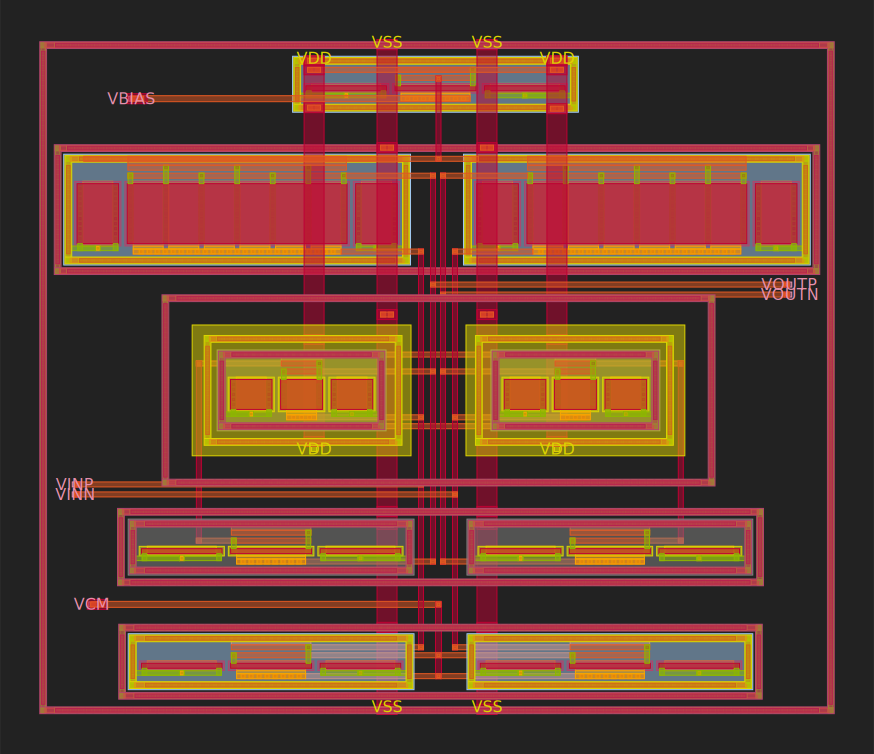

2025-09-22 19:31:34.903 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmphd5nagys/INA11.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmphd5nagys/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "INA11$19".
[INFO]: Loading INA11

Creating new cell
Loading DRC CIF 

In [25]:
## Activate if necessary to install following packages

# !pip install svgutils
# !pip install ipywidgets

############################################################
# IMPORT FROM LIB, DECLARE FUNC, ETC.
############################################################
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout import via_stack, via_array

############################################################
# DEFINITION OF NMOS/PMOS
############################################################
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}
pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

# DISTANCE FOR SHIFTING (FREELY)
x_distance = 5 #jarak horizontal antar komponen
y_distance = 5 #jarak vertikal antar komponen

#########################################################
# - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
########################################################
pmos_input_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (6,6), # width of the input fet and feedback fet respectively.
        "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_input_config["pdk"]
pdk.activate()
width=pmos_input_config["width"]
length=pmos_input_config["length"]
fingers=pmos_input_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_input_config["dummy_1"]
dummy_2=pmos_input_config["dummy_2"]
tie_layers1=pmos_input_config["tie_layers1"]
tie_layers2=pmos_input_config["tie_layers2"]
sd_rmult=pmos_input_config["sd_rmult"]

pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )

top_level = Component("PMOS_PAIR_BIAS")
pfet1_ref = top_level << pfet1
pfet2_ref = top_level << pfet2

pfet1_ref.name = "PFET1"
pfet2_ref.name = "PFET2"

placement = pmos_input_config["placement"]

#Global Variable
compSep = gf180.util_max_metal_seperation() #rule dari gf180
padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180

if placement == "horizontal":
    pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")  

# For TAP RING for PMOS PAIR only
flattened_top = top_level.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

#########################################################
# - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
########################################################
pmos_bias_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_bias_config["pdk"]
width=pmos_bias_config["width"]
length=pmos_bias_config["length"]
fingers=pmos_bias_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_bias_config["dummy_1"]
dummy_2=pmos_bias_config["dummy_2"]
tie_layers1=pmos_bias_config["tie_layers1"]
tie_layers2=pmos_bias_config["tie_layers2"]
sd_rmult=pmos_bias_config["sd_rmult"]

bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
bias_ref = top_level << bias_pmos
bias_ref.name = "PFET_Bias"
bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)

#########################################################
# - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
########################################################
nmos_input_config = {
        "pdk1": gf180,  # PDK to use
        "placement1": "horizontal",  # can be "horizontal" or "vertical"
        "width1": (3, 3),  # width of the input fet and feedback fet respectively
        "length1": (3, 3),  # length of the input fet and feedback fet respectively
        "fingers1": (1, 1),  # number of fingers for each device
        "multipliers1": (1, 1),  # multipliers for each device
        "dummy_11": (True, True),  # dummies for input fet (left, right)
        "dummy_21": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult1": 1,  # thickness of the sd metal layer
}

# Activate PDK for NMOS input stage
pdk = nmos_input_config["pdk1"]
#pdk.activate()

# Extract parameters from PMOS input config
width       = nmos_input_config["width1"]
length      = nmos_input_config["length1"]
fingers     = nmos_input_config["fingers1"]
multipliers = nmos_input_config["multipliers1"]

dummy_1     = nmos_input_config["dummy_11"]
dummy_2     = nmos_input_config["dummy_21"]
tie_layers1 = nmos_input_config["tie_layers11"]
tie_layers2 = nmos_input_config["tie_layers21"]
sd_rmult    = nmos_input_config["sd_rmult1"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
# Buat pasangan NMOS
nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level1 = Component("NMOS_INPUT_PAIR")
nfet1_ref = top_level1 << nfet1
nfet2_ref = top_level1 << nfet2
nfet1_ref.name = "NFET1"
nfet2_ref.name = "NFET2"
nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.3)
nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.5)
# Additional Tap Ring for Deep N-Well
# Additional Guard Ring for Deep N-Well (PCOMP required by DN.3)
pcomp_tapring_nfet1 = tapring(
    pdk,
    enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2),
    sdlayer="n+s/d"   # ganti dari n+ ke p+ (PCOMP guard ring)
)
pcomp_tapring_nfet2 = tapring(
    pdk,
    enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2),
    sdlayer="n+s/d"
)
tring_ref1 = top_level1 << pcomp_tapring_nfet1
tring_ref2 = top_level1 << pcomp_tapring_nfet2
tring_ref1.name = "tring_ref1_nmos"
tring_ref2.name = "tring_ref2_nmos"
tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Placement
placement = nmos_input_config["placement1"]
shift_amount =  -prec_center(nfet1_ref)[0]
if placement == "horizontal":
    nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
    tring_ref1.movex(destination=shift_amount)
    tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
###############################################################
# - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
###############################################################
nmos_current_mirror_config = {
        "pdk2": gf180,  # PDK to use
        "placement2": "horizontal",  # can be "horizontal" or "vertical"
        "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
        "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
        "fingers2": (1, 1),  # number of fingers for each device
        "multipliers2": (1, 1),  # multipliers for each device
        "dummy_12": (True, True),  # dummies for input fet (left, right)
        "dummy_22": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult2": 1,  # thickness of the sd metal layer
}
# Activate PDK for NMOS Mirror Pair
pdk = nmos_current_mirror_config["pdk2"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = nmos_current_mirror_config["width2"]
length      = nmos_current_mirror_config["length2"]
fingers     = nmos_current_mirror_config["fingers2"]
multipliers = nmos_current_mirror_config["multipliers2"]
dummy_1     = nmos_current_mirror_config["dummy_12"]
dummy_2     = nmos_current_mirror_config["dummy_22"]
tie_layers1 = nmos_current_mirror_config["tie_layers12"]
tie_layers2 = nmos_current_mirror_config["tie_layers22"]
sd_rmult    = nmos_current_mirror_config["sd_rmult2"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
# Buat pasangan NMOS
nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level2 = Component("NMOS_MIRROR")
#top_level2 = Component(name="NMOS_Mirror_Pair")
nfet3_ref = top_level2 << nfet3
nfet4_ref = top_level2 << nfet4
nfet3_ref.name = "NFET3"
nfet4_ref.name = "NFET4"
nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement
placement = nmos_current_mirror_config["placement2"]
if placement == "horizontal":
    nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
#########################################################
# - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
#########################################################
pmos_diodes_connected_config={
        "pdk3": gf180, # pdk to use
        "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_13": (True,True), # dummy pattern for input fet (left,right)
        "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult3":1, # thickness of the sd metal layer.
}
# Activate PDK for PMOS input stage
pdk = pmos_diodes_connected_config["pdk3"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = pmos_diodes_connected_config["width3"]
length      = pmos_diodes_connected_config["length3"]
fingers     = pmos_diodes_connected_config["fingers3"]
multipliers = pmos_diodes_connected_config["multipliers3"]
dummy_1     = pmos_diodes_connected_config["dummy_13"]
dummy_2     = pmos_diodes_connected_config["dummy_23"]
tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
# PMOS-DIODE Pair
pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)

# Top level component
top_level3 = Component("PMOS_DIODE_PAIR")
pfet3_ref = top_level3 << pfet3
pfet4_ref = top_level3 << pfet4
pfet3_ref.name = "PFET3"
pfet4_ref.name = "PFET4"
pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement (horizontal)
placement = pmos_diodes_connected_config["placement3"]
if placement == "horizontal":
    pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")

############################################################################################
# TOP LEVEL DECLARATION IN 1 DISPLAY
###########################################################################################
ALL_TOP = Component("ALL_TOP")

# PMOS BIAS + PMOS PAIR 
pmos_ref = ALL_TOP << top_level
pmos_ref.name = "PMOS_BIAS"
pmos_ref.movex(0)   
pmos_ref.movey(0)

# NMOS PAIR
nmos_ref = ALL_TOP << top_level1
nmos_ref.name = "NMOS_Inp_Pair"
flattened_top = top_level1.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=2.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level1 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)

# NMOS CURRENT MIRROR
cm_ref = ALL_TOP << top_level2
cm_ref.name = "NMOS_Mirror_Pair"
flattened_top = top_level2.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.12))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level2 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)

# FOR PMOS DIODE CONNECTED
pmos_diode_ref = ALL_TOP << top_level3
pmos_diode_ref.name = "PMOS_Diode_Pair"
flattened_top = top_level3.flatten()

tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level3 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

###########################################################################################################
# FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
###########################################################################################################
flattened_top = ALL_TOP.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = ALL_TOP << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

##########################################################################################################
# VIA AND ROUTING INA
##########################################################################################################
# --- VIA DEF ---
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3

# --- VIA INPUT ---
# -- IN +
via_input_P = ALL_TOP << viam2m3
via_input_P.movex(-16).movey(-27.5)
via_to_input_P = ALL_TOP << viam2m3
via_to_input_P.movex(18.4).movey(-27.5)
# -- IN - 
via_input_N = ALL_TOP << viam2m3
via_input_N.movex(-16).movey(-28.5)
via_to_input_N = ALL_TOP << viam2m3
via_to_input_N.movex(21.8).movey(-28.5)

# --- VIA OUTPUT ---
# --- OUTPUT P
via_to_output_P = ALL_TOP << viam2m3
via_output_P = ALL_TOP << viam2m3
via_to_output_P.movex(19.6).movey(-7.5)
via_output_P.movex(55).movey(-7.5)
via_to_output_P_center = via_to_output_P.center

# --- OUTPUT N
via_output_N = ALL_TOP << viam2m3
via_output_N.movex(55).movey(-8.5)
via_to_output_N = ALL_TOP << viam2m3
via_to_output_N.movex(20.6).movey(-8.5)

# --- ROUTING (Vertical on M3) ---
# SYNTAX FULL EXAMPLE (use if needed only :))
#route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
#route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
ALL_TOP << route_hori_out_P
ALL_TOP << route_hori_out_N
route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
ALL_TOP << route_hori_in_P
ALL_TOP << route_hori_in_N

# --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])

pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center
via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])

pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center
via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_L --- LEFT SIDE
nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])

nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])

nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_L --- LEFT SIDE
nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_R --- RIGHT SIDE
nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])

# ROUTE FOR OUTPUT
route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
ALL_TOP << route_vertical_out_P
route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
ALL_TOP << route_vertical_out_N

# ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
# LEFT
pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
# RIGHT
pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])

# ROUTE FOR INPUT
route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
ALL_TOP << route_vertical_in_P
route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
ALL_TOP << route_vertical_in_N

# ROUTING C ROUTE
#ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
#ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
# top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
# CROUTE WITH EXTENSION FOOT
ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))

# VIA FOR VCM WAY
viaarray = via_array(pdk, "met2", "met3", (2,1))
VCM_via = ALL_TOP << viaarray
VCM_via.movex(-14).movey(-39.5)
via_to_vcm = ALL_TOP << viam2m3
via_to_vcm.movex(20.15).movey(-39.5)
#print(VCM_via.ports.keys())

# CENTER FOR Via to VCM
pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])

pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])

# ROUTE VERTICAL VCM
route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
ALL_TOP << route_vertical_VCM
# ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
ALL_TOP << route_hori_VCM

# TIE PAIR
# -- NMOS
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
# SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
via_source_pmos_bias = ALL_TOP << viam2m3
via_source_pmos_bias.movex(20.15).movey(13.1)
# -- PMOS
pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
via_ref_conn_tie = via_source_pmos_bias.center
via_conn_tie = ALL_TOP << viam2m3
via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
# Route PMOS BIAS to SOURCE
route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
ALL_TOP << route_vertical_bias_to_source

# VIA FOR VBIAS
bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
Vbias_via = ALL_TOP << viaarray
Vbias_via.movex(-10).movey((bias_src_port.center[1]))
ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)

# TIE D/S
ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])

# VDD LEFT SIDE WAY
VDD1_a_via = ALL_TOP << viaarray
VDD2_via = ALL_TOP << viaarray
VDD3_via = ALL_TOP << viaarray
VDD4_via = ALL_TOP << viaarray
VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)

# VIA ARRAY TO SOURCE BIAS REF
bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
via_ref_vdd_bias = VDD1_a_via.center
VDD1_b_via = ALL_TOP << viaarray
VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
#ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
VDD1_c_via = ALL_TOP << viaarray
VDD1_c_via.move((32, bias_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])

# VDD RIGHT SIDE WAY **
VDD5_via = ALL_TOP << viaarray
VDD6_via = ALL_TOP << viaarray
VDD7_via = ALL_TOP << viaarray
VDD8_via = ALL_TOP << viaarray
VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)

# ---- ROUTE VDD
route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_L
route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_R

# VSS LEFT SIDE WAY
VSS1_via = ALL_TOP << viaarray
VSS2_via = ALL_TOP << viaarray
VSS3_via = ALL_TOP << viaarray
VSS4_via = ALL_TOP << viaarray
VSS5_via = ALL_TOP << viaarray
VSS6_via = ALL_TOP << viaarray
VSS7_via = ALL_TOP << viaarray
VSS1_via.movex(15).movey(16.5)
VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
VSS7_via.movex(VSS1_via.center[0]).movey(-50)

# ---- ROUTE VSS LEFT
route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_L

# VSS RIGHT SIDE WAY
VSS8_via = ALL_TOP << viaarray
VSS9_via = ALL_TOP << viaarray
VSS10_via = ALL_TOP << viaarray
VSS11_via = ALL_TOP << viaarray
VSS12_via = ALL_TOP << viaarray
VSS13_via = ALL_TOP << viaarray
VSS14_via = ALL_TOP << viaarray
VSS8_via.movex(25).movey(16.5)
VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
VSS14_via.movex(VSS8_via.center[0]).movey(-50)

# ---- ROUTE VSS RIGHT
route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_R

##########################################################################################################
# PORT FOR PAD
##########################################################################################################
ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")

ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")

ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")

component = component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

## To see all Ports
#component.pprint_ports()

##########################################################################################################
# LABELLING
##########################################################################################################
# VSS 
psize=(0.5,0.5)
move_info = list()
vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["VSS_TOPL_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOML_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_TOPR_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOMR_top_met_N"],None))
#vss_ref= ALL_TOP << vsslabel

#VDD
vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["VDD_TOPL_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_TOPR_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOML_top_met_S"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOMR_top_met_S"],None))
#vdd_ref = ALL_TOP << vddlabel

# output
outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputplabel,component.ports["OUTP_top_met_E"],None))
outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputnlabel,component.ports["OUTN_top_met_E"],None))
#output_ref = ALL_TOP << outputplabel

# input
inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
#input_ref = ALL_TOP << inputplabel

# Vbias label
vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
vbiaslabel_ref = align_comp_to_port(vbiaslabel, component.ports["VBIAS_top_met_W"], alignment=('c','c'))
vbiaslabel_ref.movex(0.4)
ALL_TOP.add(vbiaslabel_ref)
#vbias_ref = ALL_TOP << vbiaslabel

# VCM label
vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
vcmlabel_ref = align_comp_to_port(vcmlabel, component.ports["VCM_top_met_W"], alignment=('c','c'))
vcmlabel_ref.movex(0.4)
ALL_TOP.add(vcmlabel_ref)
#vcm_ref = ALL_TOP << vcmlabel
##########################################################################################################
# DISPLAY AND DRC SECTION
##########################################################################################################
for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        ALL_TOP.add(compref)
component = ALL_TOP.flatten()

#component.show()
component.name = "INA11"
component.write_gds("INA11.gds")
display_component(component, scale =1,path="../../")
drc_result = gf180.drc_magic(component, "INA11")

In [4]:
ina_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INA"))

def add_ina_labels(
    ina_in: Component,
    pdk: gf180
    ) -> Component:
    
    ina_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPL_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOML_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPR_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOMR_top_met_N"],None))
    
    #VDD
    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPL_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPR_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOML_top_met_S"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOMR_top_met_S"],None))
    
    # output
    outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputplabel,ina_in.ports["OUTP_top_met_E"],None))
    outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputnlabel,ina_in.ports["OUTN_top_met_E"],None))
    
    # input
    inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputplabel,ina_in.ports["INP_top_met_W"], None))
    inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputnlabel,ina_in.ports["INN_top_met_W"], None))
    
    # Vbias label
    vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vbiaslabel,ina_in.ports["VBIAS_top_met_W"], None))
    
    # VCM label
    vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vcmlabel,ina_in.ports["VCM_top_met_W"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            ina_in.add(compref)
    return ina_in.flatten()
    
def ina(
        pdk: gf180
        ) -> Component:

    pdk.activate()

    nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
    }
    pmos_kwargs = {
        "with_tie": True,
        "dnwell": False,
        "sd_route_topmet": "met2",
        "gate_route_topmet": "met2",
        "sd_route_left": True,
        "rmult": None,
        "gate_rmult": 1,
        "interfinger_rmult": 1,
        "substrate_tap_layers": ("met2","met1"),
        "dummy_routes": True
    }
    
    # DISTANCE FOR SHIFTING (FREELY)
    x_distance = 5 #jarak horizontal antar komponen
    y_distance = 5 #jarak vertikal antar komponen
    
    #########################################################
    # - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    pmos_input_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (6,6), # width of the input fet and feedback fet respectively.
            "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_input_config["pdk"]
    width=pmos_input_config["width"]
    length=pmos_input_config["length"]
    fingers=pmos_input_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_input_config["dummy_1"]
    dummy_2=pmos_input_config["dummy_2"]
    tie_layers1=pmos_input_config["tie_layers1"]
    tie_layers2=pmos_input_config["tie_layers2"]
    sd_rmult=pmos_input_config["sd_rmult"]
    
    pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    
    top_level = Component("PMOS_PAIR_BIAS")
    pfet1_ref = top_level << pfet1
    pfet2_ref = top_level << pfet2
    
    pfet1_ref.name = "PFET1"
    pfet2_ref.name = "PFET2"
    
    placement = pmos_input_config["placement"]
    
    #Global Variable
    compSep = gf180.util_max_metal_seperation() #rule dari gf180
    padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180
    
    if placement == "horizontal":
        pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")  
    
    # For TAP RING for PMOS PAIR only
    flattened_top = top_level.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

    #########################################################
    # - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
    ########################################################
    pmos_bias_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_bias_config["pdk"]
    width=pmos_bias_config["width"]
    length=pmos_bias_config["length"]
    fingers=pmos_bias_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_bias_config["dummy_1"]
    dummy_2=pmos_bias_config["dummy_2"]
    tie_layers1=pmos_bias_config["tie_layers1"]
    tie_layers2=pmos_bias_config["tie_layers2"]
    sd_rmult=pmos_bias_config["sd_rmult"]
    
    bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    bias_ref = top_level << bias_pmos
    bias_ref.name = "PFET_Bias"
    bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)
    
    #########################################################
    # - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    nmos_input_config = {
            "pdk1": gf180,  # PDK to use
            "placement1": "horizontal",  # can be "horizontal" or "vertical"
            "width1": (3, 3),  # width of the input fet and feedback fet respectively
            "length1": (3, 3),  # length of the input fet and feedback fet respectively
            "fingers1": (1, 1),  # number of fingers for each device
            "multipliers1": (1, 1),  # multipliers for each device
            "dummy_11": (True, True),  # dummies for input fet (left, right)
            "dummy_21": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult1": 1,  # thickness of the sd metal layer
    }
    
    # Activate PDK for NMOS input stage
    pdk = nmos_input_config["pdk1"]
    #pdk.activate()
    
    # Extract parameters from PMOS input config
    width       = nmos_input_config["width1"]
    length      = nmos_input_config["length1"]
    fingers     = nmos_input_config["fingers1"]
    multipliers = nmos_input_config["multipliers1"]
    
    dummy_1     = nmos_input_config["dummy_11"]
    dummy_2     = nmos_input_config["dummy_21"]
    tie_layers1 = nmos_input_config["tie_layers11"]
    tie_layers2 = nmos_input_config["tie_layers21"]
    sd_rmult    = nmos_input_config["sd_rmult1"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
    # Buat pasangan NMOS
    nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level1 = Component("NMOS_INPUT_PAIR")
    nfet1_ref = top_level1 << nfet1
    nfet2_ref = top_level1 << nfet2
    nfet1_ref.name = "NFET1"
    nfet2_ref.name = "NFET2"
    nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Additional Tap Ring for Deep N-Well
    dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
    dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
    tring_ref1 = top_level1 << dnwell_tapring_nfet1
    tring_ref2 = top_level1 << dnwell_tapring_nfet2
    tring_ref1.name = "tring_ref1_pmos"
    tring_ref2.name = "tring_ref2_pmos"
    tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    #tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Placement
    placement = nmos_input_config["placement1"]
    shift_amount =  -prec_center(nfet1_ref)[0]
    if placement == "horizontal":
        nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
        tring_ref1.movex(destination=shift_amount)
        tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ###############################################################
    # - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
    ###############################################################
    nmos_current_mirror_config = {
            "pdk2": gf180,  # PDK to use
            "placement2": "horizontal",  # can be "horizontal" or "vertical"
            "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
            "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
            "fingers2": (1, 1),  # number of fingers for each device
            "multipliers2": (1, 1),  # multipliers for each device
            "dummy_12": (True, True),  # dummies for input fet (left, right)
            "dummy_22": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult2": 1,  # thickness of the sd metal layer
    }
    # Activate PDK for NMOS Mirror Pair
    pdk = nmos_current_mirror_config["pdk2"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = nmos_current_mirror_config["width2"]
    length      = nmos_current_mirror_config["length2"]
    fingers     = nmos_current_mirror_config["fingers2"]
    multipliers = nmos_current_mirror_config["multipliers2"]
    dummy_1     = nmos_current_mirror_config["dummy_12"]
    dummy_2     = nmos_current_mirror_config["dummy_22"]
    tie_layers1 = nmos_current_mirror_config["tie_layers12"]
    tie_layers2 = nmos_current_mirror_config["tie_layers22"]
    sd_rmult    = nmos_current_mirror_config["sd_rmult2"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
    # Buat pasangan NMOS
    nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level2 = Component("NMOS_MIRROR")
    #top_level2 = Component(name="NMOS_Mirror_Pair")
    nfet3_ref = top_level2 << nfet3
    nfet4_ref = top_level2 << nfet4
    nfet3_ref.name = "NFET3"
    nfet4_ref.name = "NFET4"
    nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement
    placement = nmos_current_mirror_config["placement2"]
    if placement == "horizontal":
        nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
        
    #########################################################
    # - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
    #########################################################
    pmos_diodes_connected_config={
            "pdk3": gf180, # pdk to use
            "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_13": (True,True), # dummy pattern for input fet (left,right)
            "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult3":1, # thickness of the sd metal layer.
    }
    # Activate PDK for PMOS input stage
    pdk = pmos_diodes_connected_config["pdk3"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = pmos_diodes_connected_config["width3"]
    length      = pmos_diodes_connected_config["length3"]
    fingers     = pmos_diodes_connected_config["fingers3"]
    multipliers = pmos_diodes_connected_config["multipliers3"]
    dummy_1     = pmos_diodes_connected_config["dummy_13"]
    dummy_2     = pmos_diodes_connected_config["dummy_23"]
    tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
    tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
    sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
    # PMOS-DIODE Pair
    pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    
    # Top level component
    top_level3 = Component("PMOS_DIODE_PAIR")
    pfet3_ref = top_level3 << pfet3
    pfet4_ref = top_level3 << pfet4
    pfet3_ref.name = "PFET3"
    pfet4_ref.name = "PFET4"
    pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement (horizontal)
    placement = pmos_diodes_connected_config["placement3"]
    if placement == "horizontal":
        pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ############################################################################################
    # TOP LEVEL DECLARATION IN 1 DISPLAY
    ###########################################################################################
    ALL_TOP = Component("ALL_TOP")
    
    # PMOS BIAS + PMOS PAIR 
    pmos_ref = ALL_TOP << top_level
    pmos_ref.name = "PMOS_BIAS"
    pmos_ref.movex(0)   
    pmos_ref.movey(0)
    
    # NMOS PAIR
    nmos_ref = ALL_TOP << top_level1
    nmos_ref.name = "NMOS_Inp_Pair"
    flattened_top = top_level1.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level1 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)
    
    # NMOS CURRENT MIRROR
    cm_ref = ALL_TOP << top_level2
    cm_ref.name = "NMOS_Mirror_Pair"
    flattened_top = top_level2.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level2 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    
    # FOR PMOS DIODE CONNECTED
    pmos_diode_ref = ALL_TOP << top_level3
    pmos_diode_ref.name = "PMOS_Diode_Pair"
    flattened_top = top_level3.flatten()
    
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level3 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

    ALL_TOP.info["pmos_pair"] = top_level
    ALL_TOP.info["nmos_pair"] = top_level1
    
    ###########################################################################################################
    # FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
    ###########################################################################################################
    flattened_top = ALL_TOP.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = ALL_TOP << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    
    ##########################################################################################################
    # VIA AND ROUTING INA
    ##########################################################################################################
    # --- VIA DEF ---
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3
    
    # --- VIA INPUT ---
    # -- IN +
    via_input_P = ALL_TOP << viam2m3
    via_input_P.movex(-16).movey(-27.5)
    via_to_input_P = ALL_TOP << viam2m3
    via_to_input_P.movex(18.4).movey(-27.5)
    # -- IN - 
    via_input_N = ALL_TOP << viam2m3
    via_input_N.movex(-16).movey(-28.5)
    via_to_input_N = ALL_TOP << viam2m3
    via_to_input_N.movex(21.8).movey(-28.5)
    
    # --- VIA OUTPUT ---
    # --- OUTPUT P
    via_to_output_P = ALL_TOP << viam2m3
    via_output_P = ALL_TOP << viam2m3
    via_to_output_P.movex(19.6).movey(-7.5)
    via_output_P.movex(55).movey(-7.5)
    via_to_output_P_center = via_to_output_P.center
    
    # --- OUTPUT N
    via_output_N = ALL_TOP << viam2m3
    via_output_N.movex(55).movey(-8.5)
    via_to_output_N = ALL_TOP << viam2m3
    via_to_output_N.movex(20.6).movey(-8.5)
    
    # --- ROUTING (Vertical on M3) ---
    # SYNTAX FULL EXAMPLE (use if needed only :))
    #route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
    #route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
    route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
    route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_out_P
    ALL_TOP << route_hori_out_N
    route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
    route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_in_P
    ALL_TOP << route_hori_in_N
    
    # --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
    pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])
    
    pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
    pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center
    via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])
    
    pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center
    via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_L --- LEFT SIDE
    nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])
    
    nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
    nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])
    
    nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_L --- LEFT SIDE
    nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_R --- RIGHT SIDE
    nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])
    
    # ROUTE FOR OUTPUT
    route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
    ALL_TOP << route_vertical_out_P
    route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
    ALL_TOP << route_vertical_out_N
    
    # ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
    # LEFT
    pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
    # RIGHT
    pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])
    
    # ROUTE FOR INPUT
    route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
    ALL_TOP << route_vertical_in_P
    route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
    ALL_TOP << route_vertical_in_N
    
    # ROUTING C ROUTE
    #ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
    #ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
    # top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    # CROUTE WITH EXTENSION FOOT
    ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
    ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))
    
    # VIA FOR VCM WAY
    viaarray = via_array(pdk, "met2", "met3", (2,1))
    VCM_via = ALL_TOP << viaarray
    VCM_via.movex(-14).movey(-39.5)
    via_to_vcm = ALL_TOP << viam2m3
    via_to_vcm.movex(20.15).movey(-39.5)
    #print(VCM_via.ports.keys())
    
    # CENTER FOR Via to VCM
    pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
    via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])
    
    pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
    via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])
    
    # ROUTE VERTICAL VCM
    route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
    ALL_TOP << route_vertical_VCM
    # ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
    route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
    ALL_TOP << route_hori_VCM
    
    # TIE PAIR
    # -- NMOS
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
    # SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
    via_source_pmos_bias = ALL_TOP << viam2m3
    via_source_pmos_bias.movex(20.15).movey(13.1)
    # -- PMOS
    pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
    via_ref_conn_tie = via_source_pmos_bias.center
    via_conn_tie = ALL_TOP << viam2m3
    via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
    pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
    ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
    # Route PMOS BIAS to SOURCE
    route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
    ALL_TOP << route_vertical_bias_to_source
    
    # VIA FOR VBIAS
    bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
    Vbias_via = ALL_TOP << viaarray
    Vbias_via.movex(-10).movey((bias_src_port.center[1]))
    ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)
    
    # TIE D/S
    ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])
    
    # VDD LEFT SIDE WAY
    VDD1_a_via = ALL_TOP << viaarray
    VDD2_via = ALL_TOP << viaarray
    VDD3_via = ALL_TOP << viaarray
    VDD4_via = ALL_TOP << viaarray
    VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
    VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
    VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
    VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)
    
    # VIA ARRAY TO SOURCE BIAS REF
    bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
    via_ref_vdd_bias = VDD1_a_via.center
    VDD1_b_via = ALL_TOP << viaarray
    VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
    #ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
    VDD1_c_via = ALL_TOP << viaarray
    VDD1_c_via.move((32, bias_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])
    
    # VDD RIGHT SIDE WAY **
    VDD5_via = ALL_TOP << viaarray
    VDD6_via = ALL_TOP << viaarray
    VDD7_via = ALL_TOP << viaarray
    VDD8_via = ALL_TOP << viaarray
    VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
    VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
    VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
    VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)
    
    # ---- ROUTE VDD
    route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_L
    route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_R
    
    # VSS LEFT SIDE WAY
    VSS1_via = ALL_TOP << viaarray
    VSS2_via = ALL_TOP << viaarray
    VSS3_via = ALL_TOP << viaarray
    VSS4_via = ALL_TOP << viaarray
    VSS5_via = ALL_TOP << viaarray
    VSS6_via = ALL_TOP << viaarray
    VSS7_via = ALL_TOP << viaarray
    VSS1_via.movex(15).movey(16.5)
    VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
    VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
    VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
    VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
    VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
    VSS7_via.movex(VSS1_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS LEFT
    route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_L
    
    # VSS RIGHT SIDE WAY
    VSS8_via = ALL_TOP << viaarray
    VSS9_via = ALL_TOP << viaarray
    VSS10_via = ALL_TOP << viaarray
    VSS11_via = ALL_TOP << viaarray
    VSS12_via = ALL_TOP << viaarray
    VSS13_via = ALL_TOP << viaarray
    VSS14_via = ALL_TOP << viaarray
    VSS8_via.movex(25).movey(16.5)
    VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
    VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
    VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
    VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
    VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
    VSS14_via.movex(VSS8_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS RIGHT
    route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_R
    
    ##########################################################################################################
    # PORT FOR PAD
    ##########################################################################################################
    ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
    ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
    ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
    ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")
    
    ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
    ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
    ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
    ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")
    
    ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
    ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
    ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
    ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")
    
    ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
    ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")
    
    return component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

if __name__ == "__main__":
\tcomp = ina(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_ina_labels(comp, gf180)\n
\tcomp.name = "INA"\n
\tcomp.write_gds('out_INA.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "INA")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCH import cswitch,add_cswitch_labels

__all__ = [
    'cswitch',
    'add_cswitch_labels',
] 
"""

directory = "../../INA/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_INA.py", "w") as file:
    file.write(ina_code_string)

2025-09-10 12:51:32.968 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active
2025-09-10 12:51:51.017 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'INA11.gds'


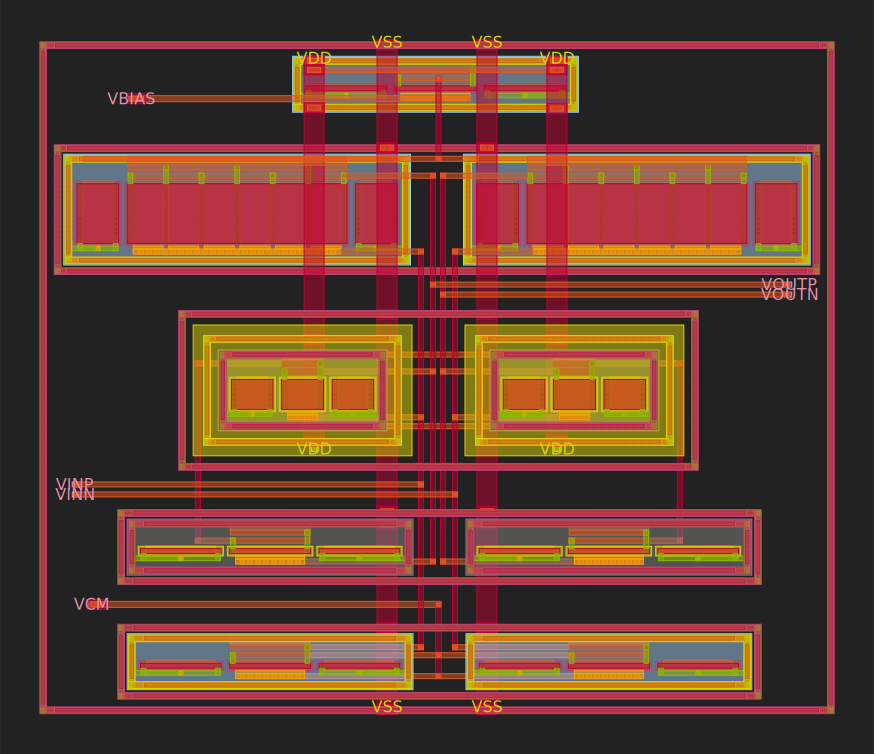

2025-09-10 12:51:51.524 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmp4ona8_eq/INA11.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmp4ona8_eq/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "INA11".
[INFO]: Loading INA11

Loading DRC CIF style.
No errors foun

In [1]:
## Activate if necessary to install following packages

# !pip install svgutils
# !pip install ipywidgets

############################################################
# IMPORT FROM LIB, DECLARE FUNC, ETC.
############################################################
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route
from glayout import via_stack, via_array

############################################################
# DEFINITION OF NMOS/PMOS
############################################################
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}
pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

# DISTANCE FOR SHIFTING (FREELY)
x_distance = 5 #jarak horizontal antar komponen
y_distance = 5 #jarak vertikal antar komponen

#########################################################
# - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
########################################################
pmos_input_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (6,6), # width of the input fet and feedback fet respectively.
        "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_input_config["pdk"]
pdk.activate()
width=pmos_input_config["width"]
length=pmos_input_config["length"]
fingers=pmos_input_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_input_config["dummy_1"]
dummy_2=pmos_input_config["dummy_2"]
tie_layers1=pmos_input_config["tie_layers1"]
tie_layers2=pmos_input_config["tie_layers2"]
sd_rmult=pmos_input_config["sd_rmult"]

pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )

top_level = Component("PMOS_PAIR_BIAS")
pfet1_ref = top_level << pfet1
pfet2_ref = top_level << pfet2

pfet1_ref.name = "PFET1"
pfet2_ref.name = "PFET2"

placement = pmos_input_config["placement"]

#Global Variable
compSep = gf180.util_max_metal_seperation() #rule dari gf180
padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180

if placement == "horizontal":
    pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")  

# For TAP RING for PMOS PAIR only
flattened_top = top_level.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

#########################################################
# - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
########################################################
pmos_bias_config={
        "pdk": gf180, # pdk to use
        "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
pdk=pmos_bias_config["pdk"]
width=pmos_bias_config["width"]
length=pmos_bias_config["length"]
fingers=pmos_bias_config["fingers"]
multipliers=pmos_input_config["multipliers"]

dummy_1=pmos_bias_config["dummy_1"]
dummy_2=pmos_bias_config["dummy_2"]
tie_layers1=pmos_bias_config["tie_layers1"]
tie_layers2=pmos_bias_config["tie_layers2"]
sd_rmult=pmos_bias_config["sd_rmult"]

bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
bias_ref = top_level << bias_pmos
bias_ref.name = "PFET_Bias"
bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)

#########################################################
# - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
########################################################
nmos_input_config = {
        "pdk1": gf180,  # PDK to use
        "placement1": "horizontal",  # can be "horizontal" or "vertical"
        "width1": (3, 3),  # width of the input fet and feedback fet respectively
        "length1": (3, 3),  # length of the input fet and feedback fet respectively
        "fingers1": (1, 1),  # number of fingers for each device
        "multipliers1": (1, 1),  # multipliers for each device
        "dummy_11": (True, True),  # dummies for input fet (left, right)
        "dummy_21": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult1": 1,  # thickness of the sd metal layer
}

# Activate PDK for NMOS input stage
pdk = nmos_input_config["pdk1"]
#pdk.activate()

# Extract parameters from PMOS input config
width       = nmos_input_config["width1"]
length      = nmos_input_config["length1"]
fingers     = nmos_input_config["fingers1"]
multipliers = nmos_input_config["multipliers1"]

dummy_1     = nmos_input_config["dummy_11"]
dummy_2     = nmos_input_config["dummy_21"]
tie_layers1 = nmos_input_config["tie_layers11"]
tie_layers2 = nmos_input_config["tie_layers21"]
sd_rmult    = nmos_input_config["sd_rmult1"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
# Buat pasangan NMOS
nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level1 = Component("NMOS_INPUT_PAIR")
nfet1_ref = top_level1 << nfet1
nfet2_ref = top_level1 << nfet2
nfet1_ref.name = "NFET1"
nfet2_ref.name = "NFET2"
nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Additional Tap Ring for Deep N-Well
dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
tring_ref1 = top_level1 << dnwell_tapring_nfet1
tring_ref2 = top_level1 << dnwell_tapring_nfet2
tring_ref1.name = "tring_ref1_pmos"
tring_ref2.name = "tring_ref2_pmos"
tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
#tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
# Placement
placement = nmos_input_config["placement1"]
shift_amount =  -prec_center(nfet1_ref)[0]
if placement == "horizontal":
    nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
    tring_ref1.movex(destination=shift_amount)
    tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
###############################################################
# - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
###############################################################
nmos_current_mirror_config = {
        "pdk2": gf180,  # PDK to use
        "placement2": "horizontal",  # can be "horizontal" or "vertical"
        "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
        "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
        "fingers2": (1, 1),  # number of fingers for each device
        "multipliers2": (1, 1),  # multipliers for each device
        "dummy_12": (True, True),  # dummies for input fet (left, right)
        "dummy_22": (True, True),  # dummies for feedback fet (left, right)
        "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
        "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
        "sd_rmult2": 1,  # thickness of the sd metal layer
}
# Activate PDK for NMOS Mirror Pair
pdk = nmos_current_mirror_config["pdk2"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = nmos_current_mirror_config["width2"]
length      = nmos_current_mirror_config["length2"]
fingers     = nmos_current_mirror_config["fingers2"]
multipliers = nmos_current_mirror_config["multipliers2"]
dummy_1     = nmos_current_mirror_config["dummy_12"]
dummy_2     = nmos_current_mirror_config["dummy_22"]
tie_layers1 = nmos_current_mirror_config["tie_layers12"]
tie_layers2 = nmos_current_mirror_config["tie_layers22"]
sd_rmult    = nmos_current_mirror_config["sd_rmult2"]

# Tambahkan kwargs NMOS
nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
# Buat pasangan NMOS
nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)

# Top level component
top_level2 = Component("NMOS_MIRROR")
#top_level2 = Component(name="NMOS_Mirror_Pair")
nfet3_ref = top_level2 << nfet3
nfet4_ref = top_level2 << nfet4
nfet3_ref.name = "NFET3"
nfet4_ref.name = "NFET4"
nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement
placement = nmos_current_mirror_config["placement2"]
if placement == "horizontal":
    nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")
    
#########################################################
# - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
#########################################################
pmos_diodes_connected_config={
        "pdk3": gf180, # pdk to use
        "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
        "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
        "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_13": (True,True), # dummy pattern for input fet (left,right)
        "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult3":1, # thickness of the sd metal layer.
}
# Activate PDK for PMOS input stage
pdk = pmos_diodes_connected_config["pdk3"]
#pdk.activate()
# Extract parameters from PMOS input config
width       = pmos_diodes_connected_config["width3"]
length      = pmos_diodes_connected_config["length3"]
fingers     = pmos_diodes_connected_config["fingers3"]
multipliers = pmos_diodes_connected_config["multipliers3"]
dummy_1     = pmos_diodes_connected_config["dummy_13"]
dummy_2     = pmos_diodes_connected_config["dummy_23"]
tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
# PMOS-DIODE Pair
pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)

# Top level component
top_level3 = Component("PMOS_DIODE_PAIR")
pfet3_ref = top_level3 << pfet3
pfet4_ref = top_level3 << pfet4
pfet3_ref.name = "PFET3"
pfet4_ref.name = "PFET4"
pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
# Placement (horizontal)
placement = pmos_diodes_connected_config["placement3"]
if placement == "horizontal":
    pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
else:
    raise ValueError("Error: placement must be 'horizontal'")

############################################################################################
# TOP LEVEL DECLARATION IN 1 DISPLAY
###########################################################################################
ALL_TOP = Component("ALL_TOP")

# PMOS BIAS + PMOS PAIR 
pmos_ref = ALL_TOP << top_level
pmos_ref.name = "PMOS_BIAS"
pmos_ref.movex(0)   
pmos_ref.movey(0)

# NMOS PAIR
nmos_ref = ALL_TOP << top_level1
nmos_ref.name = "NMOS_Inp_Pair"
flattened_top = top_level1.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level1 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)

# NMOS CURRENT MIRROR
cm_ref = ALL_TOP << top_level2
cm_ref.name = "NMOS_Mirror_Pair"
flattened_top = top_level2.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level2 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)

# FOR PMOS DIODE CONNECTED
pmos_diode_ref = ALL_TOP << top_level3
pmos_diode_ref.name = "PMOS_Diode_Pair"
flattened_top = top_level3.flatten()

tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = top_level3 << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
#pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

###########################################################################################################
# FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
###########################################################################################################
flattened_top = ALL_TOP.flatten()
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
shift_amount = -prec_center(flattened_top)[0]
shifty_amount = -prec_center(flattened_top)[1]
tring_ref = ALL_TOP << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

##########################################################################################################
# VIA AND ROUTING INA
##########################################################################################################
# --- VIA DEF ---
viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3

# --- VIA INPUT ---
# -- IN +
via_input_P = ALL_TOP << viam2m3
via_input_P.movex(-16).movey(-27.5)
via_to_input_P = ALL_TOP << viam2m3
via_to_input_P.movex(18.4).movey(-27.5)
# -- IN - 
via_input_N = ALL_TOP << viam2m3
via_input_N.movex(-16).movey(-28.5)
via_to_input_N = ALL_TOP << viam2m3
via_to_input_N.movex(21.8).movey(-28.5)

# --- VIA OUTPUT ---
# --- OUTPUT P
via_to_output_P = ALL_TOP << viam2m3
via_output_P = ALL_TOP << viam2m3
via_to_output_P.movex(19.6).movey(-7.5)
via_output_P.movex(55).movey(-7.5)
via_to_output_P_center = via_to_output_P.center

# --- OUTPUT N
via_output_N = ALL_TOP << viam2m3
via_output_N.movex(55).movey(-8.5)
via_to_output_N = ALL_TOP << viam2m3
via_to_output_N.movex(20.6).movey(-8.5)

# --- ROUTING (Vertical on M3) ---
# SYNTAX FULL EXAMPLE (use if needed only :))
#route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
#route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
ALL_TOP << route_hori_out_P
ALL_TOP << route_hori_out_N
route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
ALL_TOP << route_hori_in_P
ALL_TOP << route_hori_in_N

# --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])

pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center
via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])

pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center
via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_L --- LEFT SIDE
nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])

nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])

# --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])

nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_L --- LEFT SIDE
nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])

# --- VIA TO NMOS_CM_R --- RIGHT SIDE
nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])

# ROUTE FOR OUTPUT
route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
ALL_TOP << route_vertical_out_P
route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
ALL_TOP << route_vertical_out_N

# ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
# LEFT
pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
# RIGHT
pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])

# ROUTE FOR INPUT
route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
ALL_TOP << route_vertical_in_P
route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
ALL_TOP << route_vertical_in_N

# ROUTING C ROUTE
#ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
#ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
# top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
# CROUTE WITH EXTENSION FOOT
ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))

# VIA FOR VCM WAY
viaarray = via_array(pdk, "met2", "met3", (2,1))
VCM_via = ALL_TOP << viaarray
VCM_via.movex(-14).movey(-39.5)
via_to_vcm = ALL_TOP << viam2m3
via_to_vcm.movex(20.15).movey(-39.5)
#print(VCM_via.ports.keys())

# CENTER FOR Via to VCM
pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])

pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])

# ROUTE VERTICAL VCM
route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
ALL_TOP << route_vertical_VCM
# ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
ALL_TOP << route_hori_VCM

# TIE PAIR
# -- NMOS
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
# SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
via_source_pmos_bias = ALL_TOP << viam2m3
via_source_pmos_bias.movex(20.15).movey(13.1)
# -- PMOS
pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
via_ref_conn_tie = via_source_pmos_bias.center
via_conn_tie = ALL_TOP << viam2m3
via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
# Route PMOS BIAS to SOURCE
route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
ALL_TOP << route_vertical_bias_to_source

# VIA FOR VBIAS
bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
Vbias_via = ALL_TOP << viaarray
Vbias_via.movex(-10).movey((bias_src_port.center[1]))
ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)

# TIE D/S
ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])

# VDD LEFT SIDE WAY
VDD1_a_via = ALL_TOP << viaarray
VDD2_via = ALL_TOP << viaarray
VDD3_via = ALL_TOP << viaarray
VDD4_via = ALL_TOP << viaarray
VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)

# VIA ARRAY TO SOURCE BIAS REF
bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
via_ref_vdd_bias = VDD1_a_via.center
VDD1_b_via = ALL_TOP << viaarray
VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
#ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
VDD1_c_via = ALL_TOP << viaarray
VDD1_c_via.move((32, bias_src_port_1.center[1]))
ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])

# VDD RIGHT SIDE WAY **
VDD5_via = ALL_TOP << viaarray
VDD6_via = ALL_TOP << viaarray
VDD7_via = ALL_TOP << viaarray
VDD8_via = ALL_TOP << viaarray
VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)

# ---- ROUTE VDD
route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_L
route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VDD_R

# VSS LEFT SIDE WAY
VSS1_via = ALL_TOP << viaarray
VSS2_via = ALL_TOP << viaarray
VSS3_via = ALL_TOP << viaarray
VSS4_via = ALL_TOP << viaarray
VSS5_via = ALL_TOP << viaarray
VSS6_via = ALL_TOP << viaarray
VSS7_via = ALL_TOP << viaarray
VSS1_via.movex(15).movey(16.5)
VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
VSS7_via.movex(VSS1_via.center[0]).movey(-50)

# ---- ROUTE VSS LEFT
route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_L

# VSS RIGHT SIDE WAY
VSS8_via = ALL_TOP << viaarray
VSS9_via = ALL_TOP << viaarray
VSS10_via = ALL_TOP << viaarray
VSS11_via = ALL_TOP << viaarray
VSS12_via = ALL_TOP << viaarray
VSS13_via = ALL_TOP << viaarray
VSS14_via = ALL_TOP << viaarray
VSS8_via.movex(25).movey(16.5)
VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
VSS14_via.movex(VSS8_via.center[0]).movey(-50)

# ---- ROUTE VSS RIGHT
route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
ALL_TOP << route_vertical_VSS_R

##########################################################################################################
# PORT FOR PAD
##########################################################################################################
ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")

ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")

ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")

component = component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

## To see all Ports
#component.pprint_ports()

##########################################################################################################
# LABELLING
##########################################################################################################
# VSS 
psize=(0.5,0.5)
move_info = list()
vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["VSS_TOPL_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOML_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_TOPR_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOMR_top_met_N"],None))
#vss_ref= ALL_TOP << vsslabel

#VDD
vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["VDD_TOPL_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_TOPR_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOML_top_met_S"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOMR_top_met_S"],None))
#vdd_ref = ALL_TOP << vddlabel

# output
outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputplabel,component.ports["OUTP_top_met_E"],None))
outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputnlabel,component.ports["OUTN_top_met_E"],None))
#output_ref = ALL_TOP << outputplabel

# input
inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
#input_ref = ALL_TOP << inputplabel

# Vbias label
vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
vbiaslabel_ref = align_comp_to_port(vbiaslabel, component.ports["VBIAS_top_met_W"], alignment=('c','c'))
vbiaslabel_ref.movex(0.4)
ALL_TOP.add(vbiaslabel_ref)
#vbias_ref = ALL_TOP << vbiaslabel

# VCM label
vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
vcmlabel_ref = align_comp_to_port(vcmlabel, component.ports["VCM_top_met_W"], alignment=('c','c'))
vcmlabel_ref.movex(0.4)
ALL_TOP.add(vcmlabel_ref)
#vcm_ref = ALL_TOP << vcmlabel
##########################################################################################################
# DISPLAY AND DRC SECTION
##########################################################################################################
for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        ALL_TOP.add(compref)
component = ALL_TOP.flatten()

#component.show()
component.name = "INA11"
component.write_gds("INA11.gds")
display_component(component, scale =1,path="../../")
drc_result = gf180.drc_magic(component, "INA11")

In [3]:
ina_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../INA"))

def add_ina_labels(
    ina_in: Component,
    pdk: gf180
    ) -> Component:
    
    ina_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPL_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOML_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_TOPR_top_met_N"],None))
    move_info.append((vsslabel,ina_in.ports["VSS_BOTTOMR_top_met_N"],None))
    
    #VDD
    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPL_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_TOPR_top_met_N"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOML_top_met_S"],None))
    move_info.append((vddlabel,ina_in.ports["VDD_BOTTOMR_top_met_S"],None))
    
    # output
    outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputplabel,ina_in.ports["OUTP_top_met_E"],None))
    outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputnlabel,ina_in.ports["OUTN_top_met_E"],None))
    
    # input
    inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputplabel,ina_in.ports["INP_top_met_W"], None))
    inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputnlabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputnlabel,ina_in.ports["INN_top_met_W"], None))
    
    # Vbias label
    vbiaslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vbiaslabel.add_label(text="VBIAS",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vbiaslabel,ina_in.ports["VBIAS_top_met_W"], None))
    
    # VCM label
    vcmlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vcmlabel.add_label(text="VCM",layer=pdk.get_glayer("met2_pin"))
    move_info.append((vcmlabel,ina_in.ports["VCM_top_met_W"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            ina_in.add(compref)
    return ina_in.flatten()
    
def ina(
        pdk: gf180
        ) -> Component:

    pdk.activate()

    nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
    }
    pmos_kwargs = {
        "with_tie": True,
        "dnwell": False,
        "sd_route_topmet": "met2",
        "gate_route_topmet": "met2",
        "sd_route_left": True,
        "rmult": None,
        "gate_rmult": 1,
        "interfinger_rmult": 1,
        "substrate_tap_layers": ("met2","met1"),
        "dummy_routes": True
    }
    
    # DISTANCE FOR SHIFTING (FREELY)
    x_distance = 5 #jarak horizontal antar komponen
    y_distance = 5 #jarak vertikal antar komponen
    
    #########################################################
    # - - - - - - - - PMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    pmos_input_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (6,6), # width of the input fet and feedback fet respectively.
            "length": (3,3), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_input_config["pdk"]
    width=pmos_input_config["width"]
    length=pmos_input_config["length"]
    fingers=pmos_input_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_input_config["dummy_1"]
    dummy_2=pmos_input_config["dummy_2"]
    tie_layers1=pmos_input_config["tie_layers1"]
    tie_layers2=pmos_input_config["tie_layers2"]
    sd_rmult=pmos_input_config["sd_rmult"]
    
    pfet1 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    pfet2 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    
    top_level = Component("PMOS_PAIR_BIAS")
    pfet1_ref = top_level << pfet1
    pfet2_ref = top_level << pfet2
    
    pfet1_ref.name = "PFET1"
    pfet2_ref.name = "PFET2"
    
    placement = pmos_input_config["placement"]
    
    #Global Variable
    compSep = gf180.util_max_metal_seperation() #rule dari gf180
    padding = pdk.get_grule("nwell", "active_diff")["min_enclosure"] #rule dari gf180
    
    if placement == "horizontal":
        pfet2_ref.movex(compSep + evaluate_bbox(pfet1)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")  
    
    # For TAP RING for PMOS PAIR only
    flattened_top = top_level.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)

    #########################################################
    # - - - - - - - - SINGLE PMOS BIAS  - - - - - - - - - - -
    ########################################################
    pmos_bias_config={
            "pdk": gf180, # pdk to use
            "placement" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_1": (True,True), # dummy pattern for input fet (left,right)
            "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult":1, # thickness of the sd metal layer.
    }
    pdk=pmos_bias_config["pdk"]
    width=pmos_bias_config["width"]
    length=pmos_bias_config["length"]
    fingers=pmos_bias_config["fingers"]
    multipliers=pmos_input_config["multipliers"]
    
    dummy_1=pmos_bias_config["dummy_1"]
    dummy_2=pmos_bias_config["dummy_2"]
    tie_layers1=pmos_bias_config["tie_layers1"]
    tie_layers2=pmos_bias_config["tie_layers2"]
    sd_rmult=pmos_bias_config["sd_rmult"]
    
    bias_pmos = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
    bias_ref = top_level << bias_pmos
    bias_ref.name = "PFET_Bias"
    bias_ref.movey(pfet1_ref.ymax + y_distance + 2).movex(pfet1_ref.xmax + x_distance/2)
    
    #########################################################
    # - - - - - - - - NMOS INPUT PAIRS - - - - - - - - - - -
    ########################################################
    nmos_input_config = {
            "pdk1": gf180,  # PDK to use
            "placement1": "horizontal",  # can be "horizontal" or "vertical"
            "width1": (3, 3),  # width of the input fet and feedback fet respectively
            "length1": (3, 3),  # length of the input fet and feedback fet respectively
            "fingers1": (1, 1),  # number of fingers for each device
            "multipliers1": (1, 1),  # multipliers for each device
            "dummy_11": (True, True),  # dummies for input fet (left, right)
            "dummy_21": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers11": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers21": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult1": 1,  # thickness of the sd metal layer
    }
    
    # Activate PDK for NMOS input stage
    pdk = nmos_input_config["pdk1"]
    #pdk.activate()
    
    # Extract parameters from PMOS input config
    width       = nmos_input_config["width1"]
    length      = nmos_input_config["length1"]
    fingers     = nmos_input_config["fingers1"]
    multipliers = nmos_input_config["multipliers1"]
    
    dummy_1     = nmos_input_config["dummy_11"]
    dummy_2     = nmos_input_config["dummy_21"]
    tie_layers1 = nmos_input_config["tie_layers11"]
    tie_layers2 = nmos_input_config["tie_layers21"]
    sd_rmult    = nmos_input_config["sd_rmult1"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = True  # NMOS (Deep N-WELL)
    # Buat pasangan NMOS
    nfet1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet2 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level1 = Component("NMOS_INPUT_PAIR")
    nfet1_ref = top_level1 << nfet1
    nfet2_ref = top_level1 << nfet2
    nfet1_ref.name = "NFET1"
    nfet2_ref.name = "NFET2"
    nfet1_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet1_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    nfet2_ref.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    nfet2_ref.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Additional Tap Ring for Deep N-Well
    dnwell_tapring_nfet1 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet1_ref, padding=padding-2), sdlayer="n+s/d")
    dnwell_tapring_nfet2 = tapring(pdk, enclosed_rectangle=evaluate_bbox(nfet2_ref, padding=padding-2), sdlayer="n+s/d")
    tring_ref1 = top_level1 << dnwell_tapring_nfet1
    tring_ref2 = top_level1 << dnwell_tapring_nfet2
    tring_ref1.name = "tring_ref1_pmos"
    tring_ref2.name = "tring_ref2_pmos"
    tring_ref1.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    #tring_ref1.movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    tring_ref2.movey(pfet1_ref.ymin*2 + shifty_amount - y_distance - 2)
    tring_ref2.movex(pfet2_ref.xmin - shift_amount - x_distance/2 + 6.4)
    # Placement
    placement = nmos_input_config["placement1"]
    shift_amount =  -prec_center(nfet1_ref)[0]
    if placement == "horizontal":
        nfet2_ref.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)  # jarak antar guard ring
        tring_ref1.movex(destination=shift_amount)
        tring_ref2.movex(compSep + evaluate_bbox(nfet1)[0] + x_distance)
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ###############################################################
    # - - - - - - - - - - CURRENT MIRROR NMOS - - - - - - - - - - -
    ###############################################################
    nmos_current_mirror_config = {
            "pdk2": gf180,  # PDK to use
            "placement2": "horizontal",  # can be "horizontal" or "vertical"
            "width2": (0.5, 0.5),  # width of the input fet and feedback fet respectively
            "length2": (6.9, 6.9),  # length of the input fet and feedback fet respectively
            "fingers2": (1, 1),  # number of fingers for each device
            "multipliers2": (1, 1),  # multipliers for each device
            "dummy_12": (True, True),  # dummies for input fet (left, right)
            "dummy_22": (True, True),  # dummies for feedback fet (left, right)
            "tie_layers12": ("met2", "met1"),  # tapering metal layers for first fet
            "tie_layers22": ("met2", "met1"),  # tapering metal layers for second fet
            "sd_rmult2": 1,  # thickness of the sd metal layer
    }
    # Activate PDK for NMOS Mirror Pair
    pdk = nmos_current_mirror_config["pdk2"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = nmos_current_mirror_config["width2"]
    length      = nmos_current_mirror_config["length2"]
    fingers     = nmos_current_mirror_config["fingers2"]
    multipliers = nmos_current_mirror_config["multipliers2"]
    dummy_1     = nmos_current_mirror_config["dummy_12"]
    dummy_2     = nmos_current_mirror_config["dummy_22"]
    tie_layers1 = nmos_current_mirror_config["tie_layers12"]
    tie_layers2 = nmos_current_mirror_config["tie_layers22"]
    sd_rmult    = nmos_current_mirror_config["sd_rmult2"]
    
    # Tambahkan kwargs NMOS
    nmos_kwargs["with_dnwell"] = False  # NMOS (P-WELL)
    # Buat pasangan NMOS
    nfet3 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    nfet4 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **nmos_kwargs)
    
    # Top level component
    top_level2 = Component("NMOS_MIRROR")
    #top_level2 = Component(name="NMOS_Mirror_Pair")
    nfet3_ref = top_level2 << nfet3
    nfet4_ref = top_level2 << nfet4
    nfet3_ref.name = "NFET3"
    nfet4_ref.name = "NFET4"
    nfet3_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    nfet4_ref.movey(nfet1_ref.ymin*2 + shifty_amount + 15.5)
    nfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement
    placement = nmos_current_mirror_config["placement2"]
    if placement == "horizontal":
        nfet4_ref.movex(compSep + evaluate_bbox(nfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
        
    #########################################################
    # - - - - - - - - - - - PMOS DIODE - - - - - - - - - - -
    #########################################################
    pmos_diodes_connected_config={
            "pdk3": gf180, # pdk to use
            "placement3" : "horizontal", # the two fets can be placed either vertically or horizontally
            "width3": (0.5,0.5), # width of the input fet and feedback fet respectively.
            "length3": (6.9,6.9), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
            "fingers3": (1,1), # no. of fingers of the input fet and feedback fet respectively.
            "multipliers3": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
            "dummy_13": (True,True), # dummy pattern for input fet (left,right)
            "dummy_23": (True,True), # dummy pattern for the feedback fet (left,right)
            "tie_layers13": ("met2","met1"), #tapring metal layers for output fet
            "tie_layers23": ("met2","met1"), #tapring metal layers for output fet
            "sd_rmult3":1, # thickness of the sd metal layer.
    }
    # Activate PDK for PMOS input stage
    pdk = pmos_diodes_connected_config["pdk3"]
    #pdk.activate()
    # Extract parameters from PMOS input config
    width       = pmos_diodes_connected_config["width3"]
    length      = pmos_diodes_connected_config["length3"]
    fingers     = pmos_diodes_connected_config["fingers3"]
    multipliers = pmos_diodes_connected_config["multipliers3"]
    dummy_1     = pmos_diodes_connected_config["dummy_13"]
    dummy_2     = pmos_diodes_connected_config["dummy_23"]
    tie_layers1 = pmos_diodes_connected_config["tie_layers13"]
    tie_layers2 = pmos_diodes_connected_config["tie_layers23"]
    sd_rmult    = pmos_diodes_connected_config["sd_rmult3"]
    # PMOS-DIODE Pair
    pfet3 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    pfet4 = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult)
    
    # Top level component
    top_level3 = Component("PMOS_DIODE_PAIR")
    pfet3_ref = top_level3 << pfet3
    pfet4_ref = top_level3 << pfet4
    pfet3_ref.name = "PFET3"
    pfet4_ref.name = "PFET4"
    pfet3_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet3_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    pfet4_ref.movey(nfet3_ref.ymin*2 + shifty_amount + 27.9)
    pfet4_ref.movex(pfet2_ref.xmin - shift_amount - x_distance - 7.8)
    # Placement (horizontal)
    placement = pmos_diodes_connected_config["placement3"]
    if placement == "horizontal":
        pfet4_ref.movex(compSep + evaluate_bbox(pfet3)[0] + x_distance)  # jarak antar guard ring
    else:
        raise ValueError("Error: placement must be 'horizontal'")
    
    ############################################################################################
    # TOP LEVEL DECLARATION IN 1 DISPLAY
    ###########################################################################################
    ALL_TOP = Component("ALL_TOP")
    
    # PMOS BIAS + PMOS PAIR 
    pmos_ref = ALL_TOP << top_level
    pmos_ref.name = "PMOS_BIAS"
    pmos_ref.movex(0)   
    pmos_ref.movey(0)
    
    # NMOS PAIR
    nmos_ref = ALL_TOP << top_level1
    nmos_ref.name = "NMOS_Inp_Pair"
    flattened_top = top_level1.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level1 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #nmos_ref.movey(nfet1_ref.ymin*2 + shifty_amount - y_distance - 2).movex(nfet2_ref.xmin - shift_amount - x_distance/2)
    
    # NMOS CURRENT MIRROR
    cm_ref = ALL_TOP << top_level2
    cm_ref.name = "NMOS_Mirror_Pair"
    flattened_top = top_level2.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level2 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #cm_ref.movey(nmos_ref.ymin + shifty_amount - y_distance - 2).movex(pfet2_ref.xmin - shift_amount - x_distance/2)
    
    # FOR PMOS DIODE CONNECTED
    pmos_diode_ref = ALL_TOP << top_level3
    pmos_diode_ref.name = "PMOS_Diode_Pair"
    flattened_top = top_level3.flatten()
    
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = top_level3 << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    #pmos_diode_ref.movey(cm_ref.ymin + shifty_amount - y_distance - 2).movex(pfet1_ref.xmax - shift_amount + x_distance/2 + 0.25)

    ALL_TOP.info["pmos_pair"] = top_level
    ALL_TOP.info["nmos_pair"] = top_level1
    
    ###########################################################################################################
    # FOR ALL_TOP (TOP LEVEL COMBINED ALL COMPONENT) THE OUTER TAPRING
    ###########################################################################################################
    flattened_top = ALL_TOP.flatten()
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(flattened_top, padding=padding+0.5))
    shift_amount = -prec_center(flattened_top)[0]
    shifty_amount = -prec_center(flattened_top)[1]
    tring_ref = ALL_TOP << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=shifty_amount)
    
    ##########################################################################################################
    # VIA AND ROUTING INA
    ##########################################################################################################
    # --- VIA DEF ---
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True)  # bottom=met2, top=met3
    
    # --- VIA INPUT ---
    # -- IN +
    via_input_P = ALL_TOP << viam2m3
    via_input_P.movex(-16).movey(-27.5)
    via_to_input_P = ALL_TOP << viam2m3
    via_to_input_P.movex(18.4).movey(-27.5)
    # -- IN - 
    via_input_N = ALL_TOP << viam2m3
    via_input_N.movex(-16).movey(-28.5)
    via_to_input_N = ALL_TOP << viam2m3
    via_to_input_N.movex(21.8).movey(-28.5)
    
    # --- VIA OUTPUT ---
    # --- OUTPUT P
    via_to_output_P = ALL_TOP << viam2m3
    via_output_P = ALL_TOP << viam2m3
    via_to_output_P.movex(19.6).movey(-7.5)
    via_output_P.movex(55).movey(-7.5)
    via_to_output_P_center = via_to_output_P.center
    
    # --- OUTPUT N
    via_output_N = ALL_TOP << viam2m3
    via_output_N.movex(55).movey(-8.5)
    via_to_output_N = ALL_TOP << viam2m3
    via_to_output_N.movex(20.6).movey(-8.5)
    
    # --- ROUTING (Vertical on M3) ---
    # SYNTAX FULL EXAMPLE (use if needed only :))
    #route_P = straight_route(pdk,via_output_P.ports["top_met_N"], via_output_N.ports["top_met_S"], width=0.5)
    #route_N = straight_route(pdk,via_input_N.ports["top_met_N"],via_output_N.ports["top_met_S"],glayer1="met2",glayer2="met2",width=pdk.get_grule("met3")["min_width"])
    route_hori_out_P = straight_route(pdk,via_to_output_P.ports["bottom_met_E"],via_output_P.ports["bottom_met_W"])
    route_hori_out_N = straight_route(pdk,via_to_output_N.ports["bottom_met_E"],via_output_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_out_P
    ALL_TOP << route_hori_out_N
    route_hori_in_P = straight_route(pdk,via_to_input_P.ports["bottom_met_E"],via_input_P.ports["bottom_met_W"])
    route_hori_in_N = straight_route(pdk,via_to_input_N.ports["bottom_met_E"],via_input_N.ports["bottom_met_W"])
    ALL_TOP << route_hori_in_P
    ALL_TOP << route_hori_in_N
    
    # --- VIA TO PMOS_PAIR_L --- LEFT SIDE + ROUTE TO VIA AT CENTER
    pfet1_src_port = pfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_L.move((via_ref_pos[0], pfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port,via_to_source_PMOS_PAIR_L.ports["bottom_met_W"])
    
    pfet1_src_port_1 = pfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_PMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_L.move((via_ref_pos_3[0], pfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_1,via_to_gate_PMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO PMOS_PAIR_R --- RIGHT SIDE + ROUTE TO VIA AT CENTER*
    pfet2_src_port = pfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center
    via_to_source_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_PMOS_PAIR_R.move((via_ref_pos_1[0], pfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port,via_to_source_PMOS_PAIR_R.ports["bottom_met_W"])
    
    pfet2_src_port_1 = pfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center
    via_to_gate_PMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_PMOS_PAIR_R.move((via_ref_pos_4[0], pfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet2_src_port_1,via_to_gate_PMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_L --- LEFT SIDE
    nfet1_src_port = nfet1_ref.ports["multiplier_0_source_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_L.move((via_ref_pos[0], nfet1_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port,via_to_source_NMOS_PAIR_L.ports["bottom_met_W"])
    
    nfet1_src_port_1 = nfet1_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_L = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_L.move((via_ref_pos_3[0], nfet1_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet1_src_port_1,via_to_gate_NMOS_PAIR_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_PAIR_R --- RIGHT SIDE
    nfet2_src_port = nfet2_ref.ports["multiplier_0_source_W"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_source_NMOS_PAIR_R.move((via_ref_pos_1[0], nfet2_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port,via_to_source_NMOS_PAIR_R.ports["bottom_met_W"])
    
    nfet2_src_port_1 = nfet2_ref.ports["multiplier_0_gate_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_gate_NMOS_PAIR_R = ALL_TOP << viam2m3
    via_to_gate_NMOS_PAIR_R.move((via_ref_pos_4[0], nfet2_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,nfet2_src_port_1,via_to_gate_NMOS_PAIR_R.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_L --- LEFT SIDE
    nfet3_src_port = nfet3_ref.ports["multiplier_0_gate_E"]
    via_ref_pos = via_to_output_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_L = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_L.move((via_ref_pos[0], nfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet3_src_port,via_to_source_NMOS_CM_L.ports["bottom_met_W"])
    
    # --- VIA TO NMOS_CM_R --- RIGHT SIDE
    nfet4_src_port = nfet4_ref.ports["multiplier_0_gate_E"]
    via_ref_pos_1 = via_to_output_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_NMOS_CM_R = ALL_TOP << viam2m3
    via_to_source_NMOS_CM_R.move((via_ref_pos_1[0], nfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,nfet4_src_port,via_to_source_NMOS_CM_R.ports["bottom_met_W"])
    
    # ROUTE FOR OUTPUT
    route_vertical_out_P = straight_route(pdk,via_to_source_PMOS_PAIR_L.ports["top_met_N"],via_to_source_NMOS_CM_L.ports["top_met_S"])
    ALL_TOP << route_vertical_out_P
    route_vertical_out_N = straight_route(pdk,via_to_source_PMOS_PAIR_R.ports["top_met_N"],via_to_source_NMOS_CM_R.ports["top_met_S"])
    ALL_TOP << route_vertical_out_N
    
    # ROUTE from PMOS DIODE-CONNECTED LEFT SIDE AND RIGHT SIDE
    # LEFT
    pfet3_src_port = pfet3_ref.ports["multiplier_0_drain_E"]
    via_ref_pos_3 = via_to_input_P.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_L = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_L.move((via_ref_pos_3[0], pfet3_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet3_src_port,via_to_drain_PMOS_DIODE_L.ports["bottom_met_W"])
    # RIGHT
    pfet4_src_port = pfet4_ref.ports["multiplier_0_drain_W"]
    via_ref_pos_4 = via_to_input_N.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_drain_PMOS_DIODE_R = ALL_TOP << viam2m3
    via_to_drain_PMOS_DIODE_R.move((via_ref_pos_4[0], pfet4_src_port.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port,via_to_drain_PMOS_DIODE_R.ports["bottom_met_W"])
    
    # ROUTE FOR INPUT
    route_vertical_in_P = straight_route(pdk,via_to_gate_PMOS_PAIR_L.ports["top_met_N"],via_to_drain_PMOS_DIODE_L.ports["top_met_S"])
    ALL_TOP << route_vertical_in_P
    route_vertical_in_N = straight_route(pdk,via_to_gate_PMOS_PAIR_R.ports["top_met_N"],via_to_drain_PMOS_DIODE_R.ports["top_met_S"])
    ALL_TOP << route_vertical_in_N
    
    # ROUTING C ROUTE
    #ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_gate_W"])
    #ALL_TOP << c_route(pdk, pfet1_ref.ports["multiplier_0_gate_W"], pfet3_ref.ports["multiplier_0_gate_W"])
    # top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    # CROUTE WITH EXTENSION FOOT
    ALL_TOP << c_route(pdk, nfet1_ref.ports["multiplier_0_drain_W"], nfet3_ref.ports["multiplier_0_source_W"], extension=6*max(width[0], width[1]))
    ALL_TOP << c_route(pdk, nfet2_ref.ports["multiplier_0_drain_E"], nfet4_ref.ports["multiplier_0_source_E"], extension=5.73*max(width[0], width[1]))
    
    # VIA FOR VCM WAY
    viaarray = via_array(pdk, "met2", "met3", (2,1))
    VCM_via = ALL_TOP << viaarray
    VCM_via.movex(-14).movey(-39.5)
    via_to_vcm = ALL_TOP << viam2m3
    via_to_vcm.movex(20.15).movey(-39.5)
    #print(VCM_via.ports.keys())
    
    # CENTER FOR Via to VCM
    pfet4_src_port_1 = pfet4_ref.ports["multiplier_0_source_W"]
    via_ref_pos_5 = via_to_vcm.center # ekuivalen sama placement movex(0).movey(0) 
    via_to_source_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_source_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_1 = pfet3_ref.ports["multiplier_0_source_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_1,via_to_source_PMOS_DIODE.ports["bottom_met_W"])
    
    pfet4_src_port_2 = pfet4_ref.ports["multiplier_0_gate_W"]
    via_to_gate_PMOS_DIODE = ALL_TOP << viam2m3
    via_to_gate_PMOS_DIODE.move((via_ref_pos_5[0], pfet4_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet4_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_E"])
    pfet3_src_port_2 = pfet3_ref.ports["multiplier_0_gate_E"]
    ALL_TOP << straight_route(pdk,pfet3_src_port_2,via_to_gate_PMOS_DIODE.ports["bottom_met_W"])
    
    # ROUTE VERTICAL VCM
    route_vertical_VCM = straight_route(pdk,via_to_vcm.ports["top_met_N"],via_to_gate_PMOS_DIODE.ports["top_met_S"], width=0.6)
    ALL_TOP << route_vertical_VCM
    # ROUTE HORIZONTAL VIA ARRAY TO VIA_TO_VCM
    route_hori_VCM = straight_route(pdk,VCM_via.ports["array_row0_col0_bottom_layer_W"],via_to_vcm.ports["bottom_met_E"],width=0.6)
    ALL_TOP << route_hori_VCM
    
    # TIE PAIR
    # -- NMOS
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_S_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_S_array_row0_col0_top_met_W"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["tie_N_array_row0_col0_top_met_E"], nfet2_ref.ports["tie_N_array_row0_col0_top_met_W"])
    # SINGLE VIA FOR TIE (PMOS PAIR, PMOS BIAS)
    via_source_pmos_bias = ALL_TOP << viam2m3
    via_source_pmos_bias.movex(20.15).movey(13.1)
    # -- PMOS
    pfet1_src_port_2 = pfet1_ref.ports["tie_N_array_row0_col0_top_met_E"]
    via_ref_conn_tie = via_source_pmos_bias.center
    via_conn_tie = ALL_TOP << viam2m3
    via_conn_tie.move((via_ref_conn_tie[0], pfet1_src_port_2.center[1]))
    ALL_TOP << straight_route(pdk,pfet1_src_port_2,via_conn_tie.ports["bottom_met_W"])
    pfet2_src_port_2 = pfet2_ref.ports["tie_N_array_row0_col0_top_met_W"]
    ALL_TOP << straight_route(pdk,pfet2_src_port_2,via_conn_tie.ports["bottom_met_E"])
    # Route PMOS BIAS to SOURCE
    route_vertical_bias_to_source = straight_route(pdk,via_source_pmos_bias.ports["top_met_N"],via_conn_tie.ports["top_met_S"])
    ALL_TOP << route_vertical_bias_to_source
    
    # VIA FOR VBIAS
    bias_src_port = bias_ref.ports["multiplier_0_gate_E"]
    Vbias_via = ALL_TOP << viaarray
    Vbias_via.movex(-10).movey((bias_src_port.center[1]))
    ALL_TOP << straight_route(pdk,bias_src_port,Vbias_via.ports["array_row0_col0_bottom_layer_W"], width = 0.6)
    
    # TIE D/S
    ALL_TOP << straight_route(pdk, pfet1_ref.ports["multiplier_0_drain_N"], pfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet2_ref.ports["multiplier_0_drain_N"], pfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet3_ref.ports["multiplier_0_drain_N"], pfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, pfet4_ref.ports["multiplier_0_drain_N"], pfet4_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet1_ref.ports["multiplier_0_drain_N"], nfet1_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet2_ref.ports["multiplier_0_drain_N"], nfet2_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet3_ref.ports["multiplier_0_drain_N"], nfet3_ref.ports["tie_N_top_met_N"])
    ALL_TOP << straight_route(pdk, nfet4_ref.ports["multiplier_0_drain_N"], nfet4_ref.ports["tie_N_top_met_N"])
    
    # VDD LEFT SIDE WAY
    VDD1_a_via = ALL_TOP << viaarray
    VDD2_via = ALL_TOP << viaarray
    VDD3_via = ALL_TOP << viaarray
    VDD4_via = ALL_TOP << viaarray
    VDD1_a_via.move(bias_ref.ports["tie_N_array_row0_col0_top_met_E"].center)
    VDD2_via.move(bias_ref.ports["tie_S_array_row0_col0_top_met_E"].center)
    VDD3_via.movex(VDD1_a_via.center[0]).movey(-13)
    VDD4_via.movex(VDD1_a_via.center[0]).movey(-23.2)
    
    # VIA ARRAY TO SOURCE BIAS REF
    bias_src_port_1 = bias_ref.ports["multiplier_0_drain_W"]
    via_ref_vdd_bias = VDD1_a_via.center
    VDD1_b_via = ALL_TOP << viaarray
    VDD1_b_via.move((via_ref_vdd_bias[0], bias_src_port_1.center[1]))
    #ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], bias_src_port_1, width = 0.8)
    VDD1_c_via = ALL_TOP << viaarray
    VDD1_c_via.move((32, bias_src_port_1.center[1]))
    ALL_TOP << straight_route(pdk,VDD1_b_via.ports["array_row0_col0_bottom_layer_W"], VDD1_c_via.ports["array_row0_col0_bottom_layer_E"])
    
    # VDD RIGHT SIDE WAY **
    VDD5_via = ALL_TOP << viaarray
    VDD6_via = ALL_TOP << viaarray
    VDD7_via = ALL_TOP << viaarray
    VDD8_via = ALL_TOP << viaarray
    VDD5_via.movex(VDD1_c_via.center[0]).movey(14.9)
    VDD6_via.movex(VDD1_c_via.center[0]).movey(10.1)
    VDD7_via.movex(VDD1_c_via.center[0]).movey(-13)
    VDD8_via.movex(VDD1_c_via.center[0]).movey(-23.2)
    
    # ---- ROUTE VDD
    route_vertical_VDD_L = straight_route(pdk,VDD1_a_via.ports["top_met_N"],VDD4_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_L
    route_vertical_VDD_R = straight_route(pdk,VDD5_via.ports["top_met_N"],VDD8_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VDD_R
    
    # VSS LEFT SIDE WAY
    VSS1_via = ALL_TOP << viaarray
    VSS2_via = ALL_TOP << viaarray
    VSS3_via = ALL_TOP << viaarray
    VSS4_via = ALL_TOP << viaarray
    VSS5_via = ALL_TOP << viaarray
    VSS6_via = ALL_TOP << viaarray
    VSS7_via = ALL_TOP << viaarray
    VSS1_via.movex(15).movey(16.5)
    VSS2_via.movex(VSS1_via.center[0]).movey(6.2)
    VSS3_via.movex(VSS1_via.center[0]).movey(-10.5)
    VSS4_via.movex(VSS1_via.center[0]).movey(-30.2)
    VSS5_via.movex(VSS1_via.center[0]).movey(-31.5)
    VSS6_via.movex(VSS1_via.center[0]).movey(-41.8)
    VSS7_via.movex(VSS1_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS LEFT
    route_vertical_VSS_L = straight_route(pdk,VSS1_via.ports["top_met_N"],VSS7_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_L
    
    # VSS RIGHT SIDE WAY
    VSS8_via = ALL_TOP << viaarray
    VSS9_via = ALL_TOP << viaarray
    VSS10_via = ALL_TOP << viaarray
    VSS11_via = ALL_TOP << viaarray
    VSS12_via = ALL_TOP << viaarray
    VSS13_via = ALL_TOP << viaarray
    VSS14_via = ALL_TOP << viaarray
    VSS8_via.movex(25).movey(16.5)
    VSS9_via.movex(VSS8_via.center[0]).movey(6.2)
    VSS10_via.movex(VSS8_via.center[0]).movey(-10.5)
    VSS11_via.movex(VSS8_via.center[0]).movey(-30.2)
    VSS12_via.movex(VSS8_via.center[0]).movey(-31.5)
    VSS13_via.movex(VSS8_via.center[0]).movey(-41.8)
    VSS14_via.movex(VSS8_via.center[0]).movey(-50)
    
    # ---- ROUTE VSS RIGHT
    route_vertical_VSS_R = straight_route(pdk,VSS8_via.ports["top_met_N"],VSS14_via.ports["top_met_S"], width = 2)
    ALL_TOP << route_vertical_VSS_R
    
    ##########################################################################################################
    # PORT FOR PAD
    ##########################################################################################################
    ALL_TOP.add_ports(via_input_P.get_ports_list(), prefix="INP_")
    ALL_TOP.add_ports(via_input_N.get_ports_list(), prefix="INN_")
    ALL_TOP.add_ports(via_output_P.get_ports_list(), prefix="OUTP_")
    ALL_TOP.add_ports(via_output_N.get_ports_list(), prefix="OUTN_")
    
    ALL_TOP.add_ports(VDD1_a_via.get_ports_list(), prefix="VDD_TOPL_")
    ALL_TOP.add_ports(VDD5_via.get_ports_list(), prefix="VDD_TOPR_")
    ALL_TOP.add_ports(VDD4_via.get_ports_list(), prefix="VDD_BOTTOML_")
    ALL_TOP.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")
    
    ALL_TOP.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOPL_")
    ALL_TOP.add_ports(VSS7_via.get_ports_list(), prefix="VSS_BOTTOML_")
    ALL_TOP.add_ports(VSS8_via.get_ports_list(), prefix="VSS_TOPR_")
    ALL_TOP.add_ports(VSS14_via.get_ports_list(), prefix="VSS_BOTTOMR_")
    
    ALL_TOP.add_ports(VCM_via.get_ports_list(), prefix="VCM_")
    ALL_TOP.add_ports(Vbias_via.get_ports_list(), prefix="VBIAS_")
    
    return component_snap_to_grid(rename_ports_by_orientation(ALL_TOP))

if __name__ == "__main__":
\tcomp = ina(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_ina_labels(comp, gf180)\n
\tcomp.name = "INA"\n
\tcomp.write_gds('out_INA.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "INA")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCH import cswitch,add_cswitch_labels

__all__ = [
    'cswitch',
    'add_cswitch_labels',
] 
"""

directory = "../../INA/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_INA.py", "w") as file:
    file.write(ina_code_string)